# Central Hidroeléctrica Yacyretá
## 08 - Modelo por desplazamiento diario del vector de predicciones,  
### Fecha: 12-Enero-22

In [1]:
# Para que funcione más rápidamente el intellisense
#%config Completer.use_jedi = False

In [2]:
#Cargo numpy y pandas para trabajar con dataframes
import pandas as pd
import numpy as np

# Cargo datetime para funciones de tiempo
from datetime import date, timedelta, datetime

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)

In [3]:
# Imports necesarios para que funcione iplot() como método de pandas
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')

In [4]:
# Planto una semilla para repetitibilidad
import random
random.seed(170162)
np.random.seed(170162)

In [5]:
import pprint
from tabulate import tabulate

In [6]:
from sktime.utils.plotting import plot_series    

### Importo los regresores

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge  

### Carpeta para los archivos '.csv' y gráficos que se generen

#### Nombre del Experimento

In [8]:
experimento = 'TFI 08G - Modelo por desplazamiento, random_state'

In [9]:
ahora = str(datetime.now()).replace(':', '-').replace(' ', '_')[:16]
path_grabacion = './output/' + experimento + '/'+ ahora + '/'
# Verifico que la carpeta exista y si no, la creo
import os
if not os.path.exists(path_grabacion):
    os.makedirs(path_grabacion)
    print('\nPath/carpeta de gráficos y de archivos creada:', path_grabacion)


Path/carpeta de gráficos y de archivos creada: ./output/TFI 08G - Modelo por desplazamiento, random_state/2022-06-05_17-41/


### Lectura del Dataset de la central hidroeléctrica Yacyretá

In [10]:
# Especifico el nombre del archivo con el dataset unificado de la CHY y el path
path = './datasets/CHY/output/'
file_name = 'CHY_dataset.csv'

In [11]:
# Leo el dataset creado en el notebook anterior
df = pd.read_csv(path + file_name)

In [12]:
# veo cabeza y cola del df
df

FECHA  COTA_EMBALSE  COTA_RESTITUCION  SALTO    QAFLR  QVBP  \
0     2011-01-01         82.04             60.17  21.87  13936.0   0.0   
1     2011-01-02         82.06             60.17  21.89  13267.0   0.0   
2     2011-01-03         82.07             60.12  21.95  12670.0   0.0   
3     2011-01-04         82.08             60.12  21.96  12909.0   0.0   
4     2011-01-05         82.13             60.08  22.05  13787.0   0.0   
...          ...           ...               ...    ...      ...   ...   
3828  2021-06-26         82.78             58.94  23.84   6545.0   0.0   
3829  2021-06-27         82.78             58.94  23.84   6337.0   0.0   
3830  2021-06-28         82.79             58.93  23.86   6138.0   0.0   
3831  2021-06-29         82.79             58.93  23.86   6133.0   0.0   
3832  2021-06-30         82.82             58.93  23.89   6151.0   0.0   

       QVBAC    QTURB     SINP       SADI  
0     1045.0  11977.0  5391.00  49384.000  
1     1045.0  11863.0  5631.60  48785.000  
2     1045.0  11439.0  6871.60  46573.000  
3     1045.0  11505.0  7460.80  46046.000  
4     1047.0  11455.0  6555.00  46721.000  
...      ...      ...      ...        ...  
3828  1017.0   5157.0  4388.60  21594.112  
3829  1017.0   5135.0  4188.42  21658.536  
3830  1017.0   5121.0  5165.92  20606.040  
3831  1017.0   5116.0  5427.90  20416.960  
3832  1017.0   5134.0  5466.60  20409.920  

[3833 rows x 10 columns]

In [13]:
# Convierto la columna FECHA de object a datetime64
df['FECHA'] = pd.to_datetime(df['FECHA'])

In [14]:
# Hago que la columna FECHA sea el índice
df.set_index('FECHA', inplace=True)

In [15]:
# Si fuera necesario imputar NAN
df = df.asfreq('D', method='ffill')

### Cargo las métricas de evaluación de desempeño

In [16]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsoluteScaledError

mae = MeanAbsoluteError()
mse = MeanSquaredError()
rmse = MeanSquaredError(square_root=True)
mase = MeanAbsoluteScaledError()

##### Genero los lags (hasta 99)

In [17]:
lags = 40
for i in range(1, lags+1):
    df['SALTO-' + str(i).zfill(2)] = df['SALTO'].shift(periods=i)
        
# Borro los registros que quedaron con un NAN al desplazarse
df.dropna(how='any', inplace=True)

### Me quedo con las features (SALTO-) como features, X

In [18]:
# Me quedo con las columnas que comienzan con 'SALTO-'
features = [col for col in df.columns if col[:6] == 'SALTO-']
X = df[features]

### Tomo la columna SALTO como target, y

In [19]:
y = df['SALTO']

#### Conjunto de horizontes de pronóstico

In [20]:
# horizontes de predicción a explorar
#fh_s = [7]
fh_s = [56, 28, 14, 7]

#### Conjunto con los números de lags a utilizar

In [21]:
#lags_s = [160]
lags_s = [40, 30, 20, 10]

#### Conjunto de regresores a utilizar

In [22]:
# Lista con los regresores
regresores = [ 
    KNeighborsRegressor()
    ,Lasso()
    ,LGBMRegressor(objective='regression', linear_tree=True)
    ,LinearRegression()
    ,MLPRegressor(max_iter=600, random_state=170162)
    ,RandomForestRegressor(criterion='absolute_error', random_state=170162) 
    ,Ridge()
    ,SVR(gamma='auto', kernel='rbf') 
    ,XGBRegressor()
    ]

### Lazo principal de cálculo

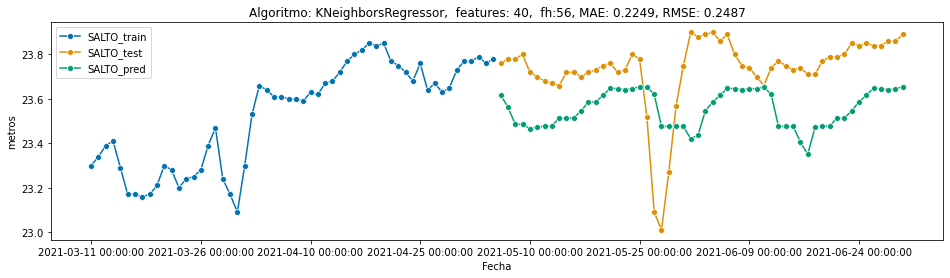

<Figure size 1152x288 with 0 Axes>

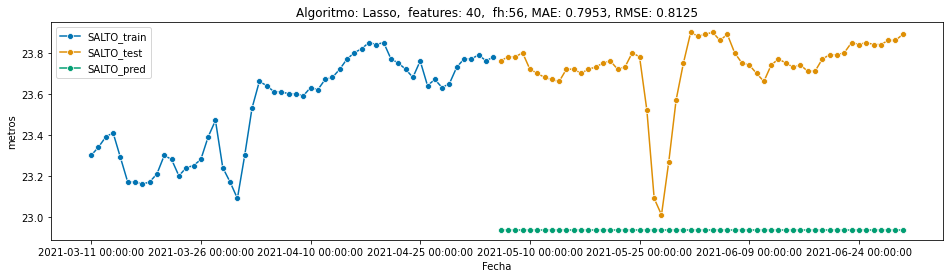

<Figure size 1152x288 with 0 Axes>

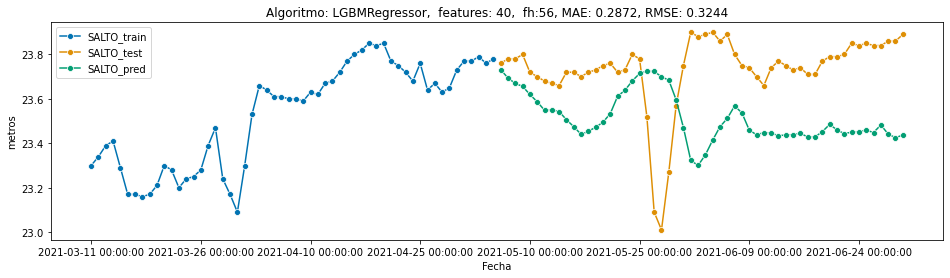

<Figure size 1152x288 with 0 Axes>

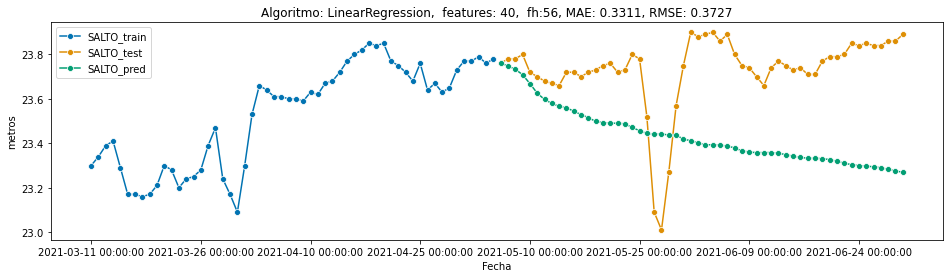

<Figure size 1152x288 with 0 Axes>

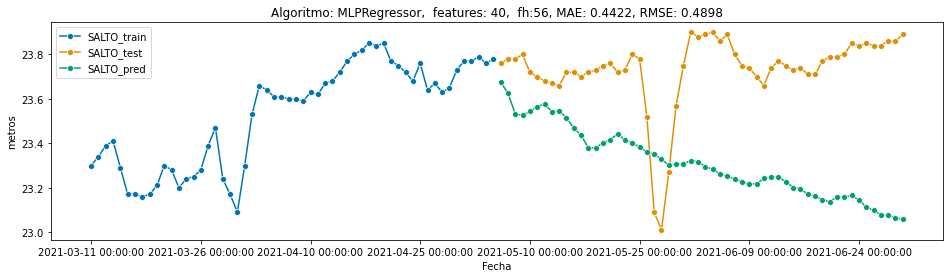

<Figure size 1152x288 with 0 Axes>

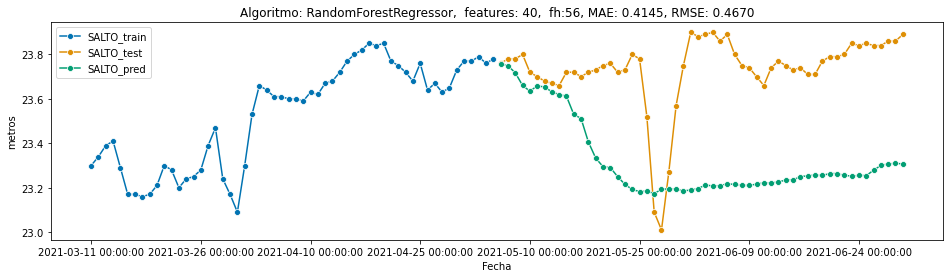

<Figure size 1152x288 with 0 Axes>

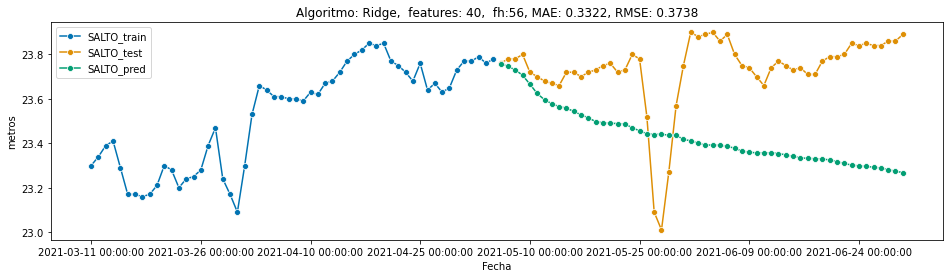

<Figure size 1152x288 with 0 Axes>

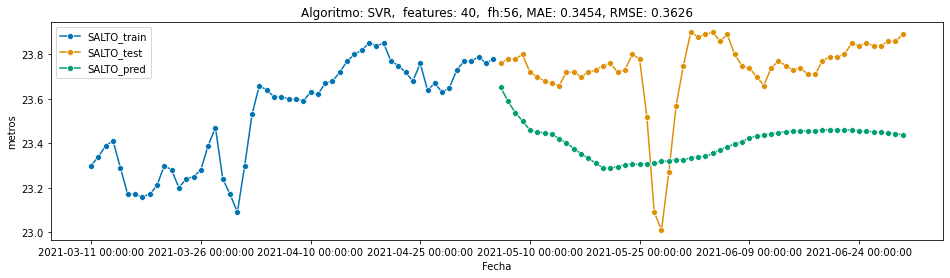

<Figure size 1152x288 with 0 Axes>

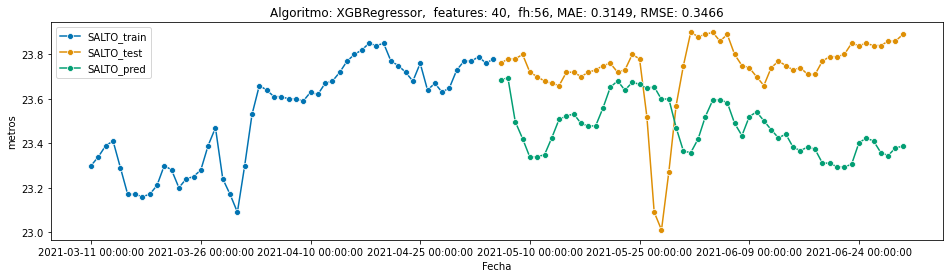

<Figure size 1152x288 with 0 Axes>

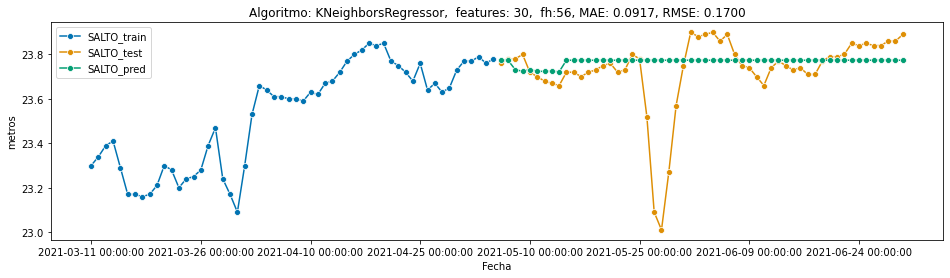

<Figure size 1152x288 with 0 Axes>

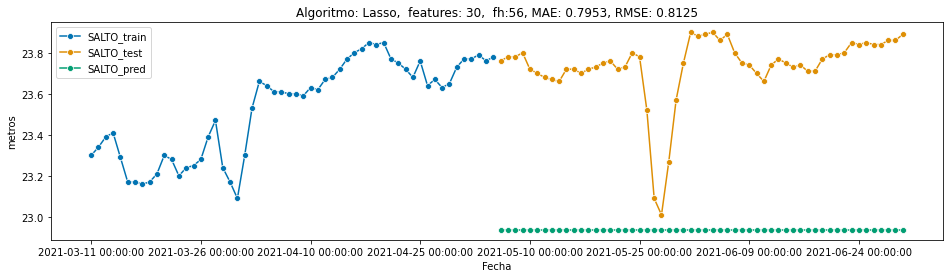

<Figure size 1152x288 with 0 Axes>

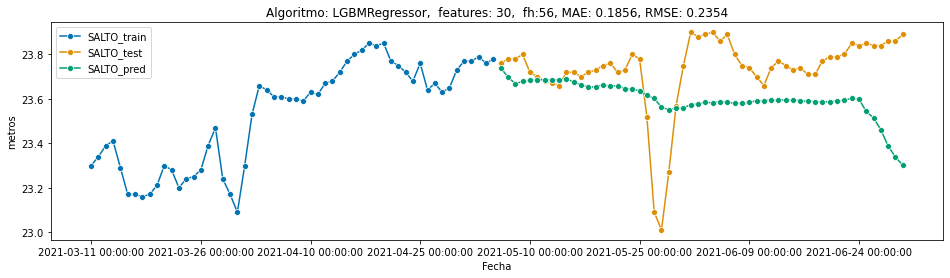

<Figure size 1152x288 with 0 Axes>

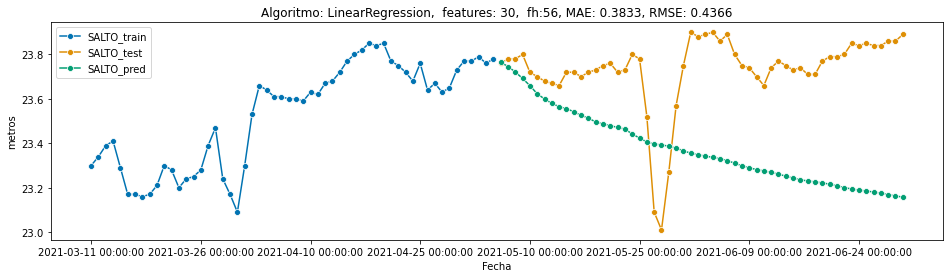

<Figure size 1152x288 with 0 Axes>

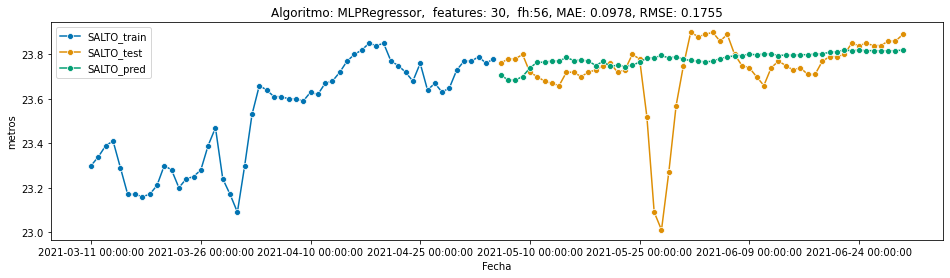

<Figure size 1152x288 with 0 Axes>

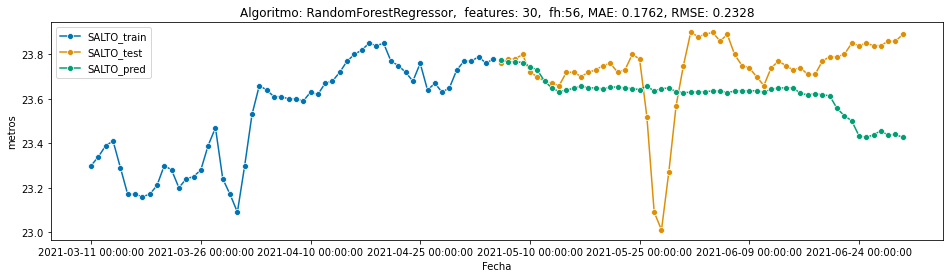

<Figure size 1152x288 with 0 Axes>

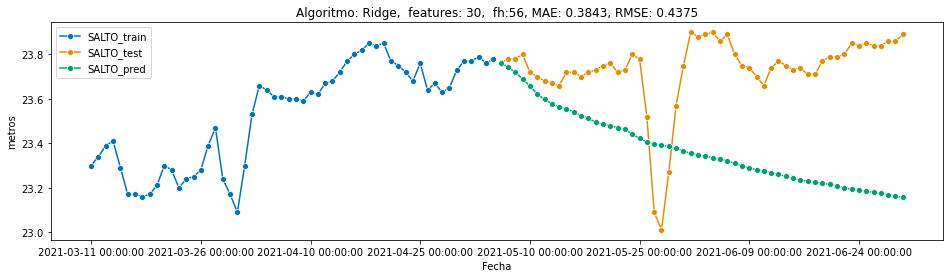

<Figure size 1152x288 with 0 Axes>

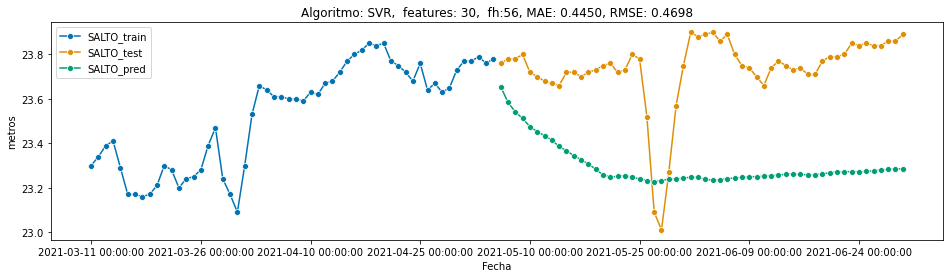

<Figure size 1152x288 with 0 Axes>

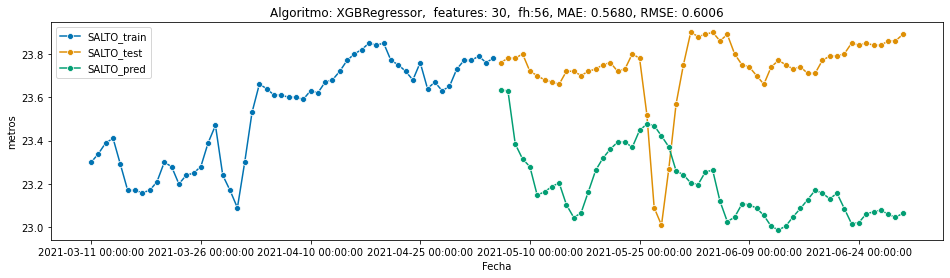

<Figure size 1152x288 with 0 Axes>

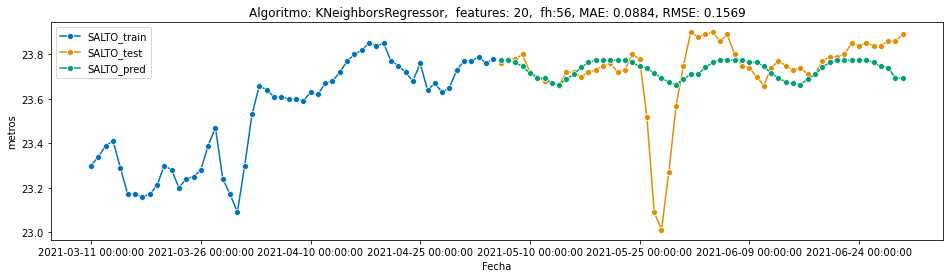

<Figure size 1152x288 with 0 Axes>

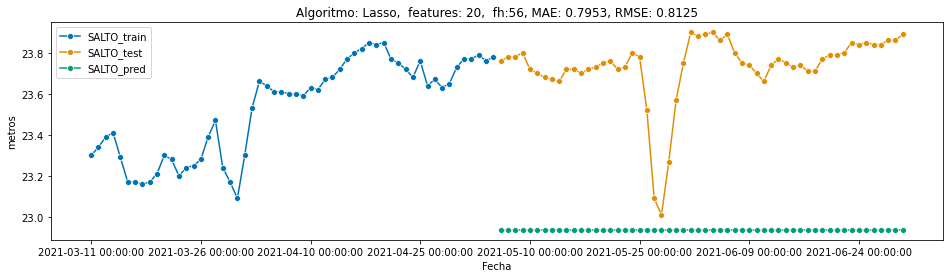

<Figure size 1152x288 with 0 Axes>

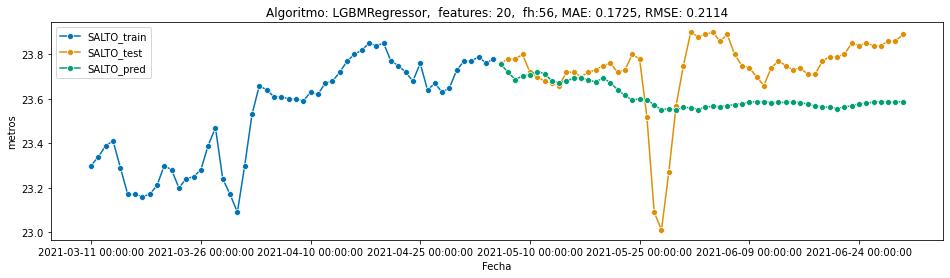

<Figure size 1152x288 with 0 Axes>

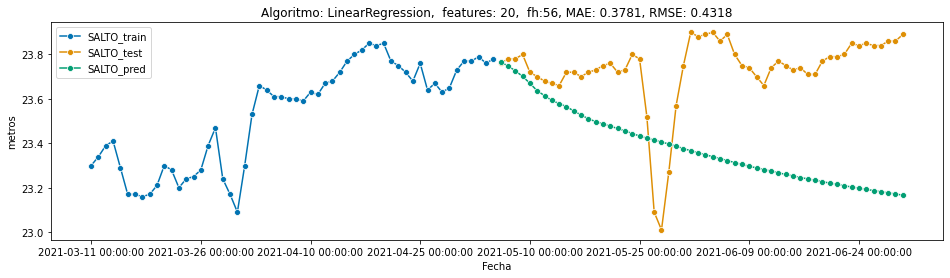

<Figure size 1152x288 with 0 Axes>

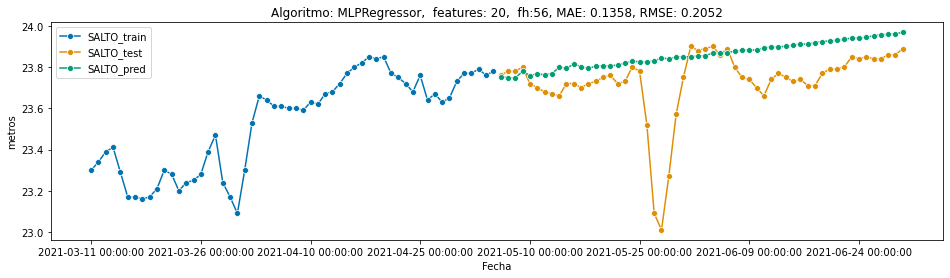

<Figure size 1152x288 with 0 Axes>

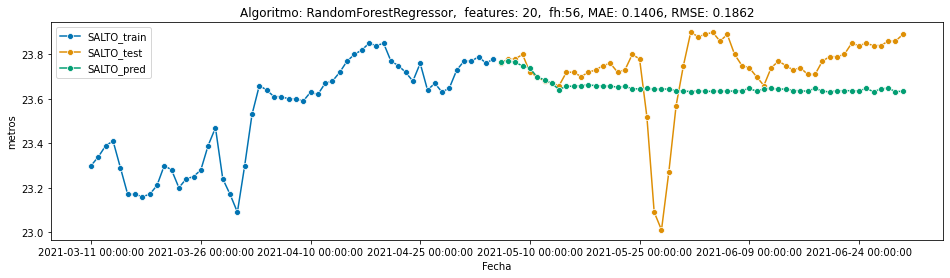

<Figure size 1152x288 with 0 Axes>

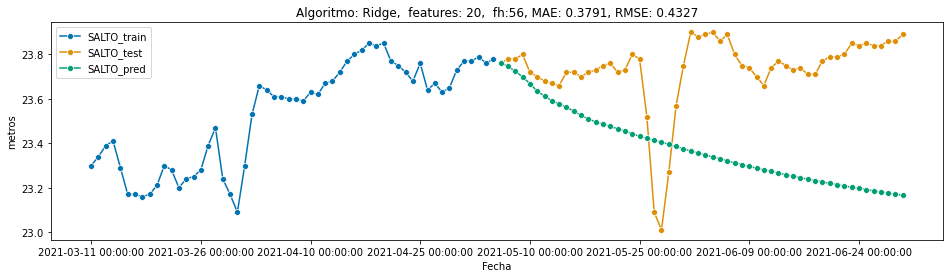

<Figure size 1152x288 with 0 Axes>

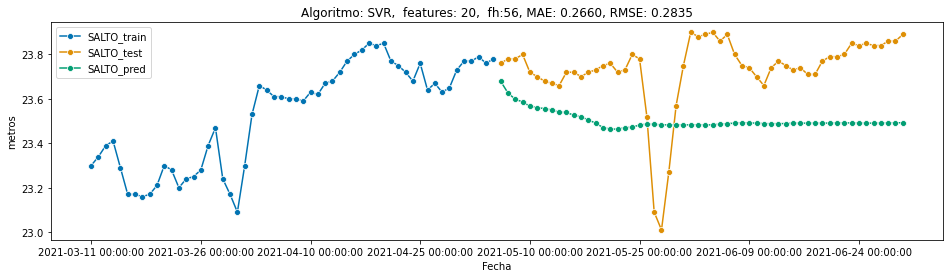

<Figure size 1152x288 with 0 Axes>

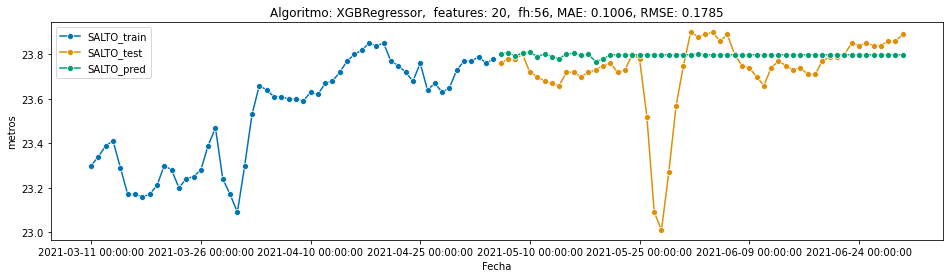

<Figure size 1152x288 with 0 Axes>

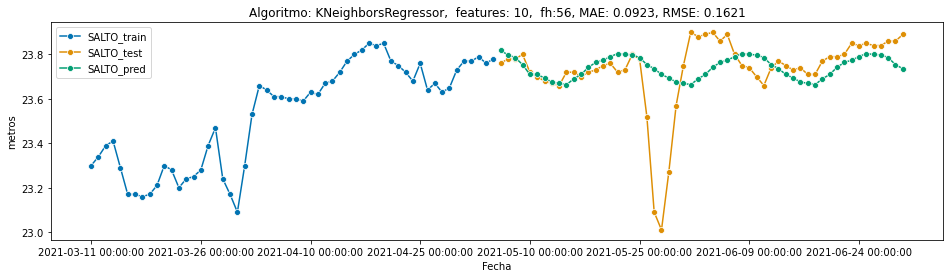

<Figure size 1152x288 with 0 Axes>

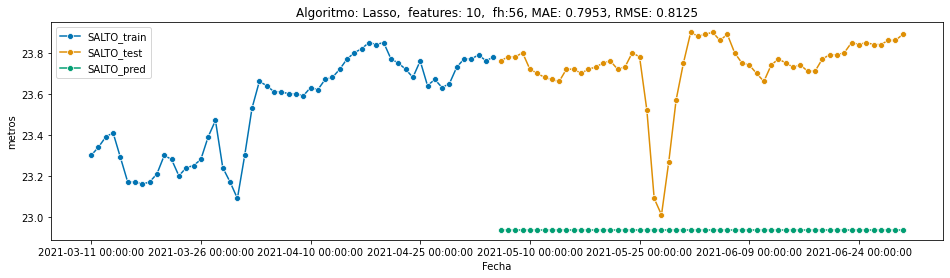

<Figure size 1152x288 with 0 Axes>

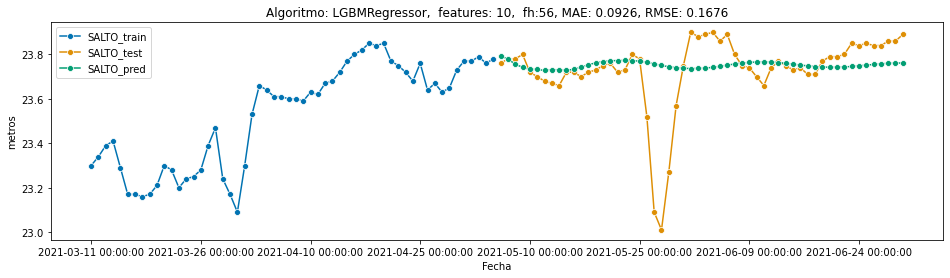

<Figure size 1152x288 with 0 Axes>

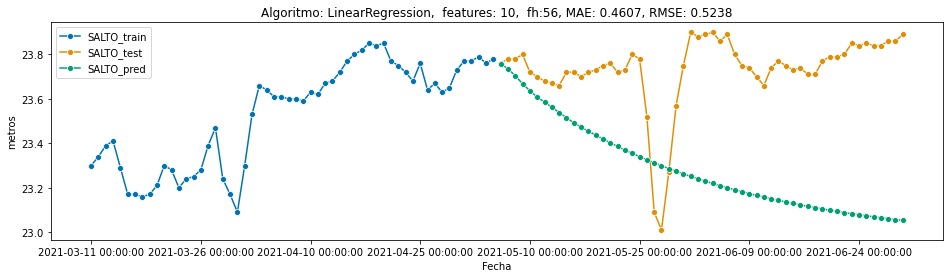

<Figure size 1152x288 with 0 Axes>

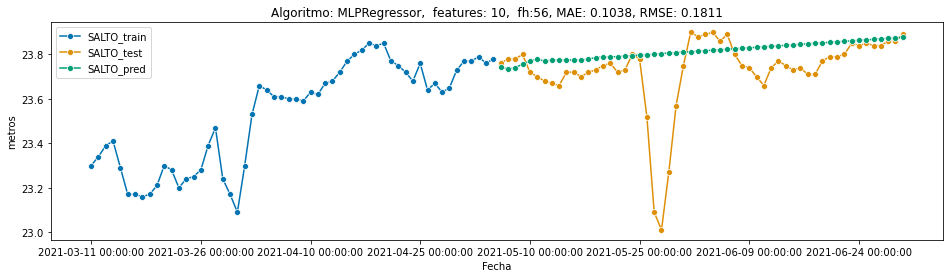

<Figure size 1152x288 with 0 Axes>

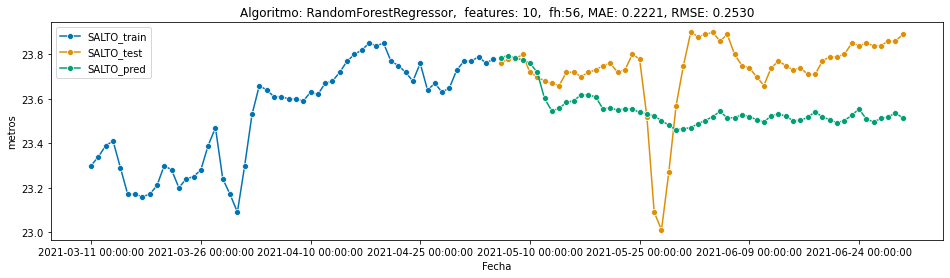

<Figure size 1152x288 with 0 Axes>

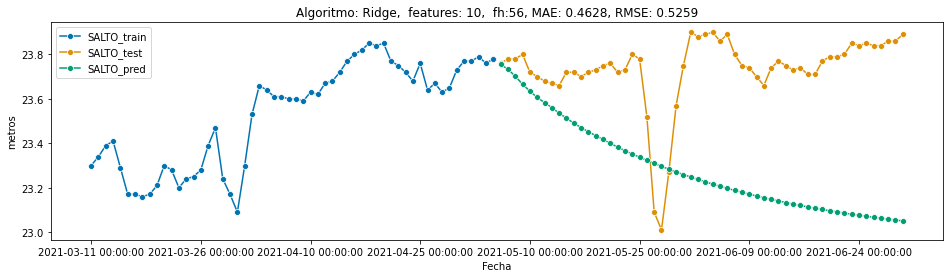

<Figure size 1152x288 with 0 Axes>

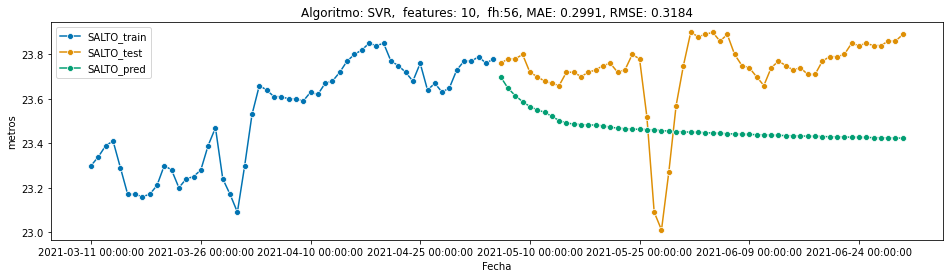

<Figure size 1152x288 with 0 Axes>

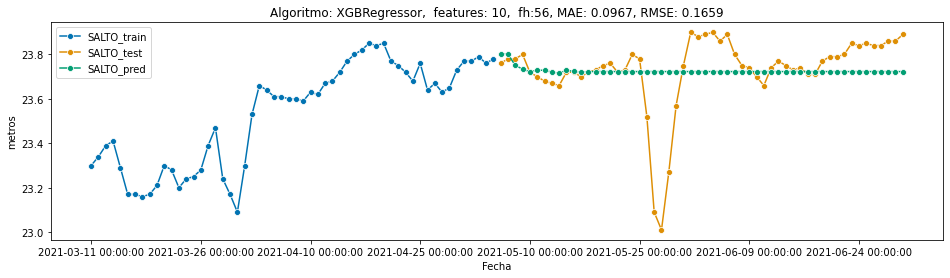

<Figure size 1152x288 with 0 Axes>

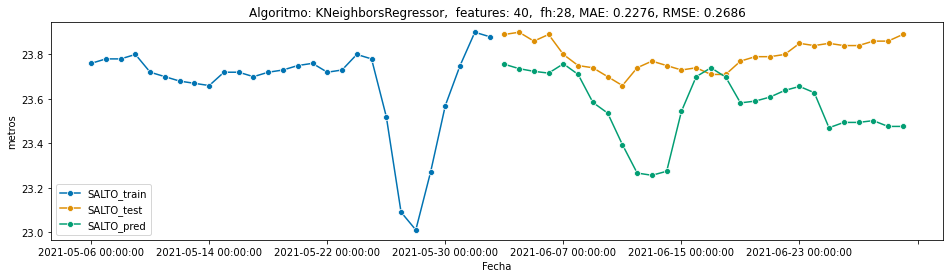

<Figure size 1152x288 with 0 Axes>

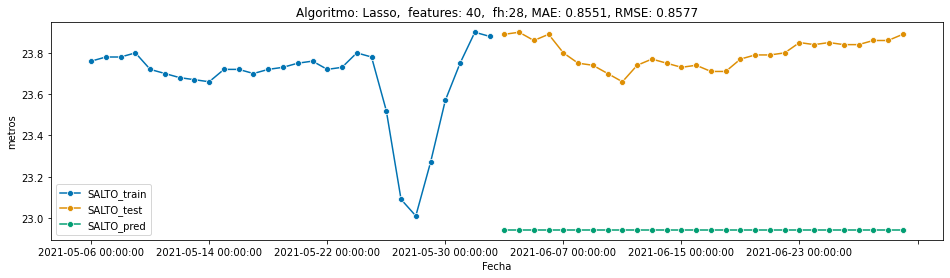

<Figure size 1152x288 with 0 Axes>

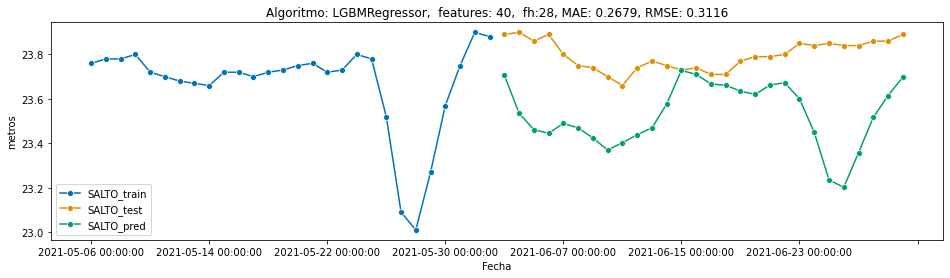

<Figure size 1152x288 with 0 Axes>

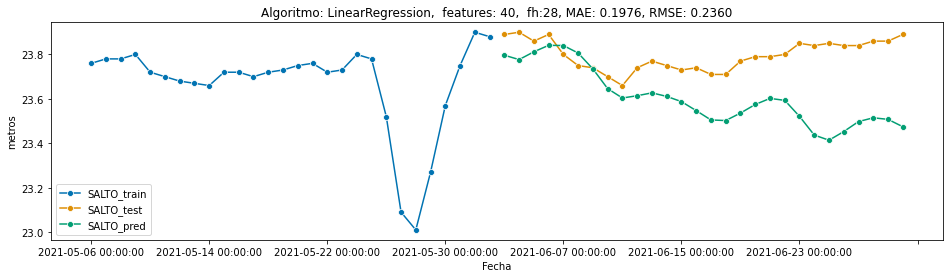

<Figure size 1152x288 with 0 Axes>

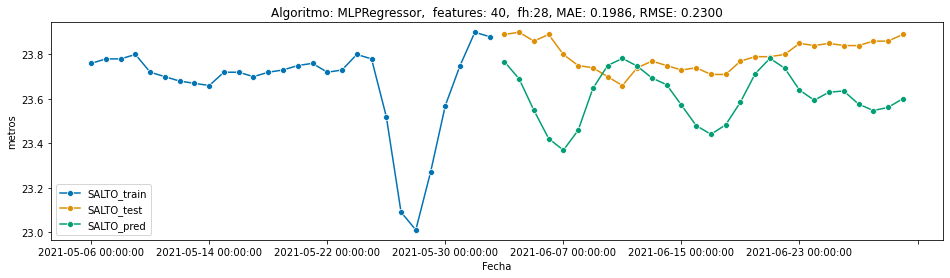

<Figure size 1152x288 with 0 Axes>

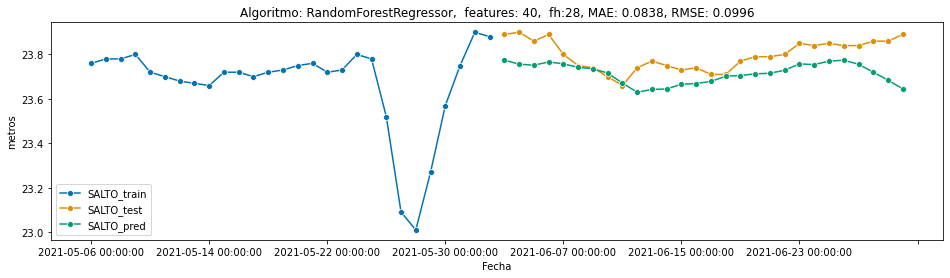

<Figure size 1152x288 with 0 Axes>

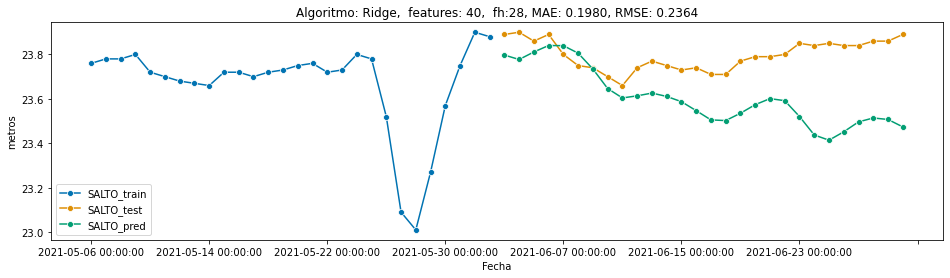

<Figure size 1152x288 with 0 Axes>

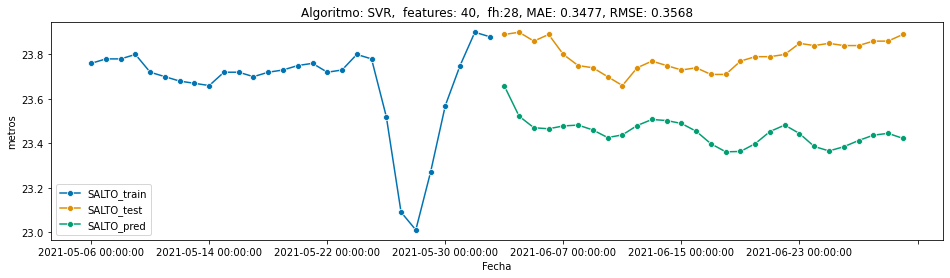

<Figure size 1152x288 with 0 Axes>

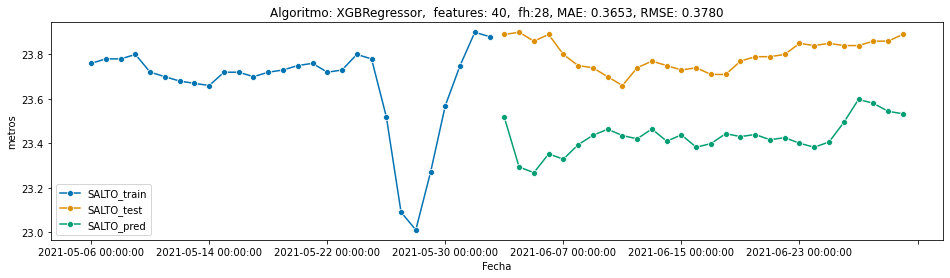

<Figure size 1152x288 with 0 Axes>

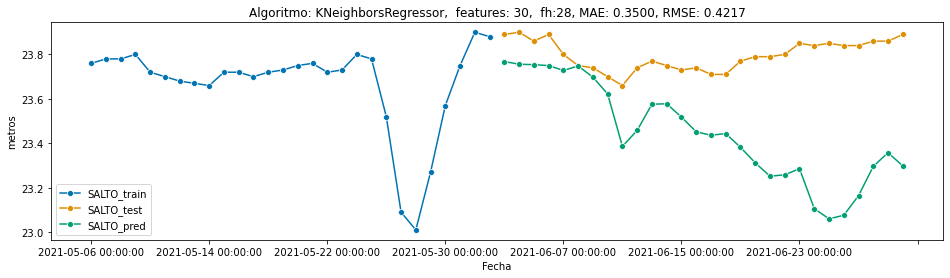

<Figure size 1152x288 with 0 Axes>

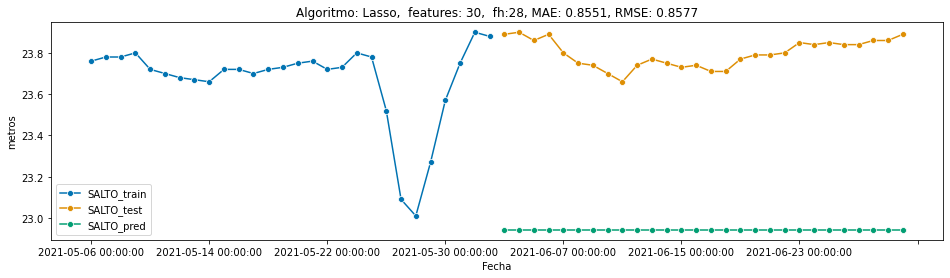

<Figure size 1152x288 with 0 Axes>

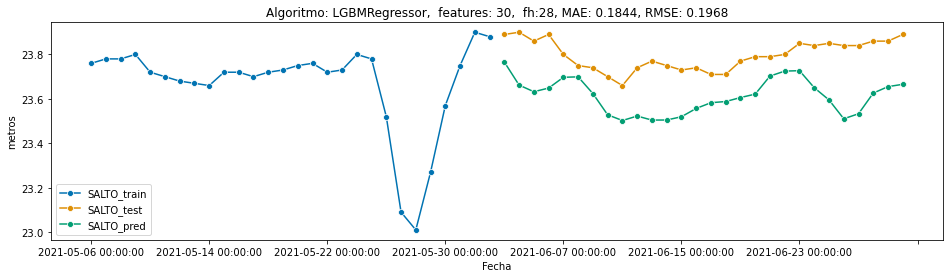

<Figure size 1152x288 with 0 Axes>

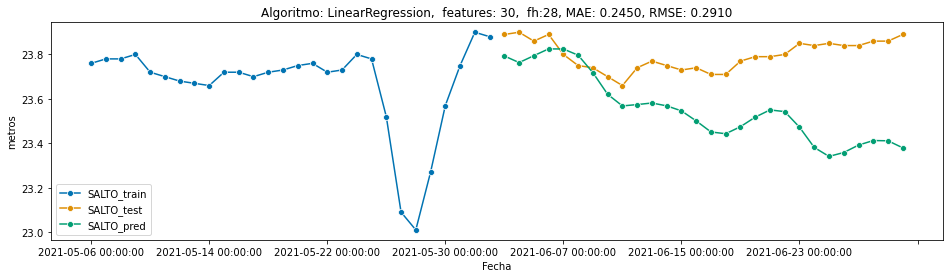

<Figure size 1152x288 with 0 Axes>

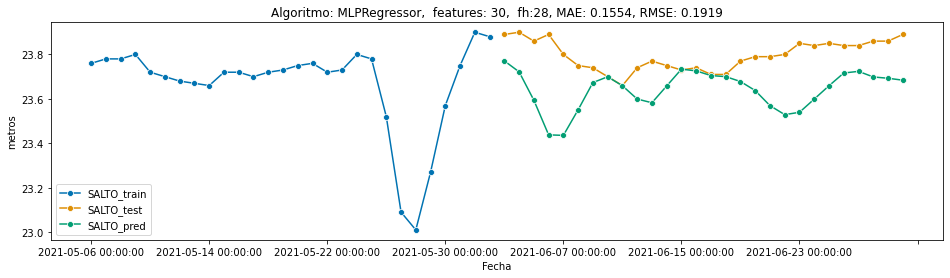

<Figure size 1152x288 with 0 Axes>

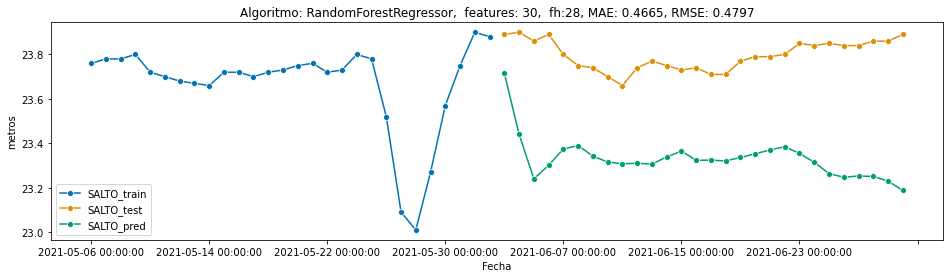

<Figure size 1152x288 with 0 Axes>

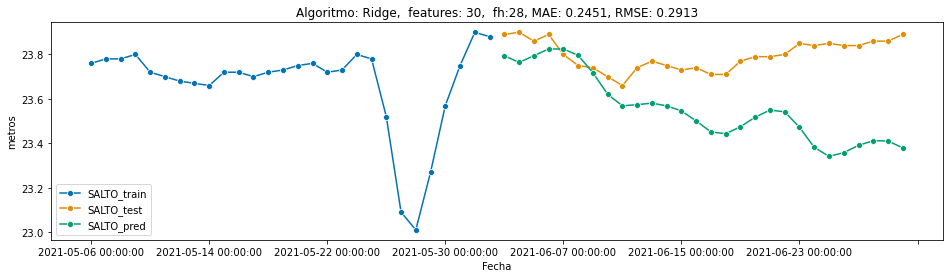

<Figure size 1152x288 with 0 Axes>

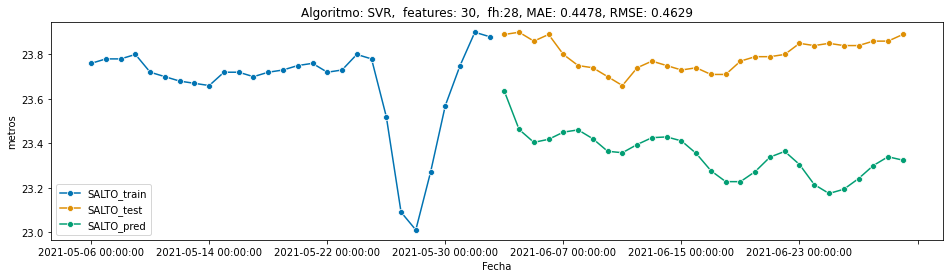

<Figure size 1152x288 with 0 Axes>

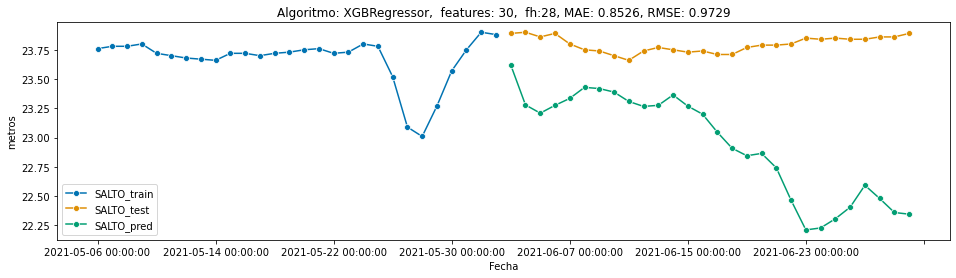

<Figure size 1152x288 with 0 Axes>

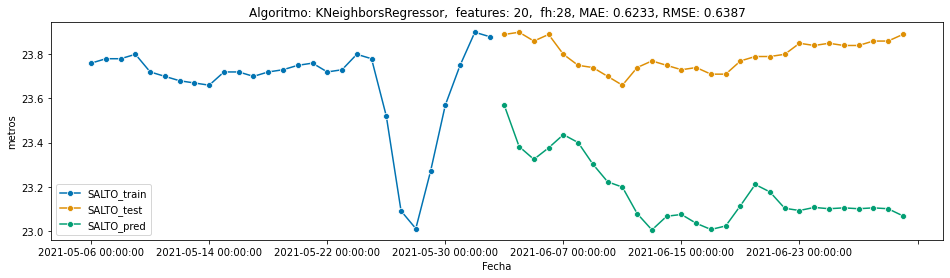

<Figure size 1152x288 with 0 Axes>

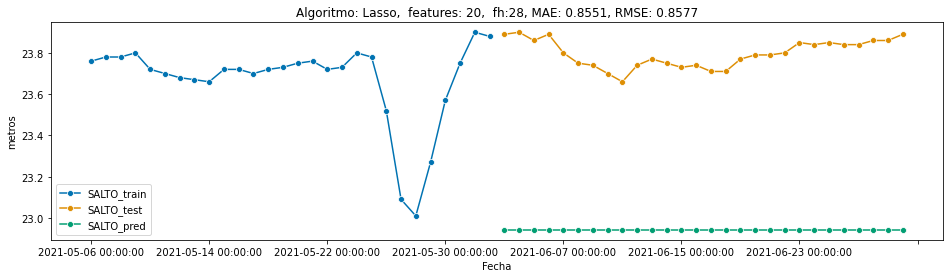

<Figure size 1152x288 with 0 Axes>

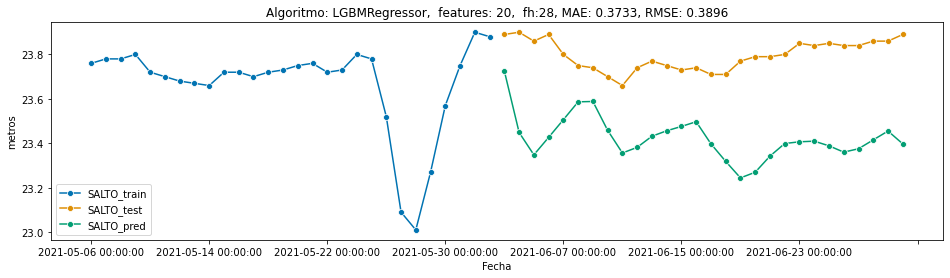

<Figure size 1152x288 with 0 Axes>

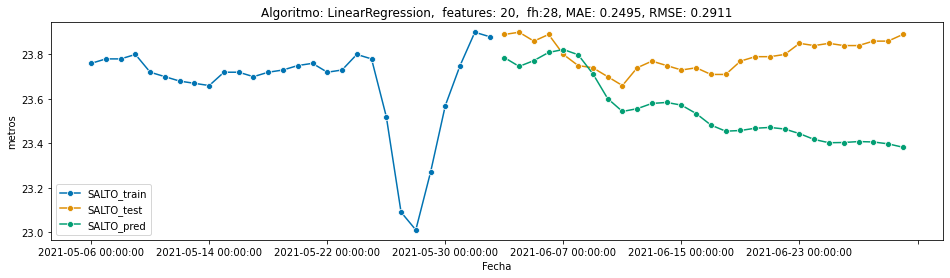

<Figure size 1152x288 with 0 Axes>

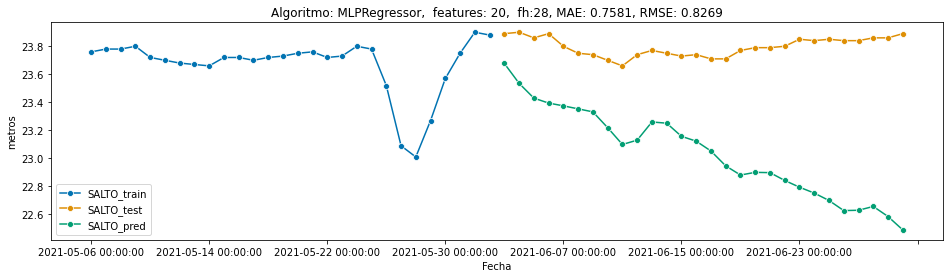

<Figure size 1152x288 with 0 Axes>

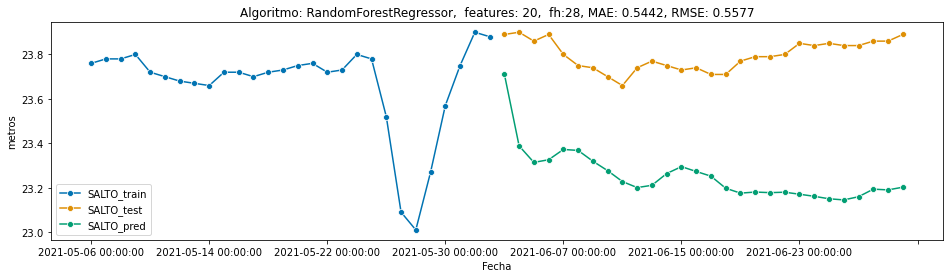

<Figure size 1152x288 with 0 Axes>

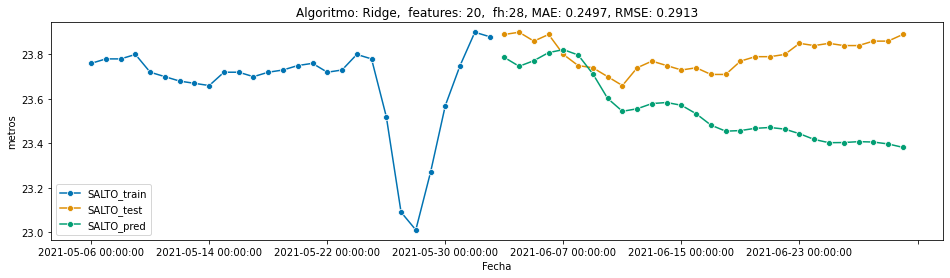

<Figure size 1152x288 with 0 Axes>

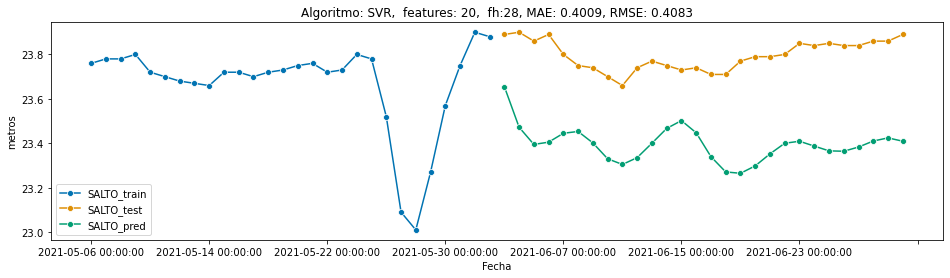

<Figure size 1152x288 with 0 Axes>

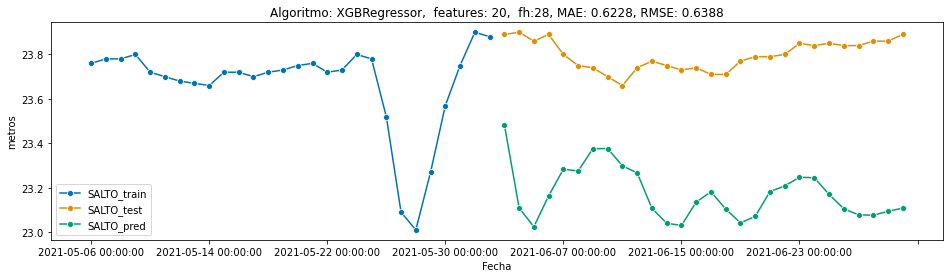

<Figure size 1152x288 with 0 Axes>

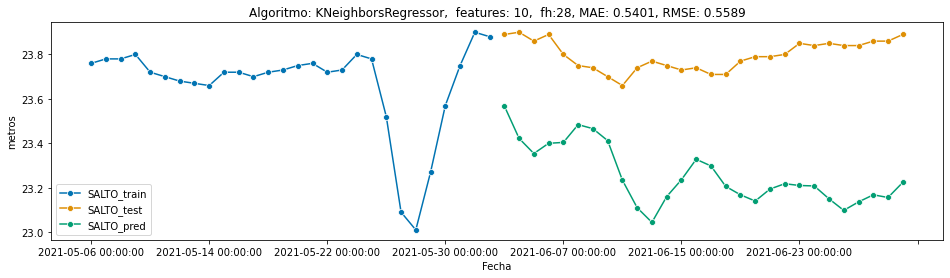

<Figure size 1152x288 with 0 Axes>

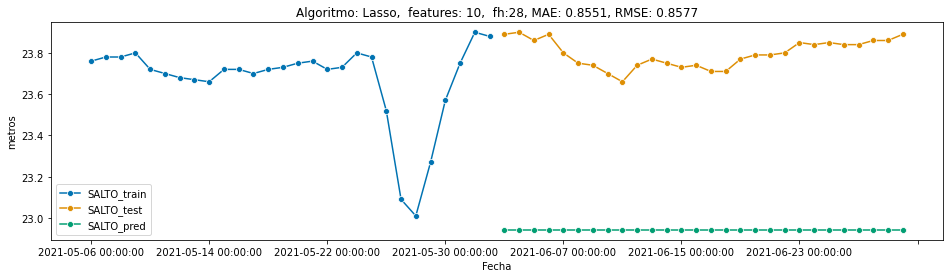

<Figure size 1152x288 with 0 Axes>

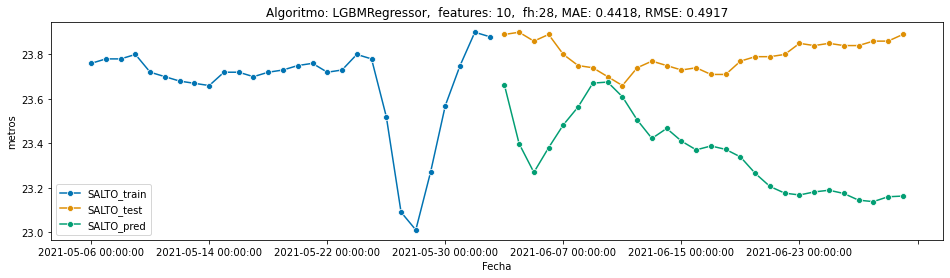

<Figure size 1152x288 with 0 Axes>

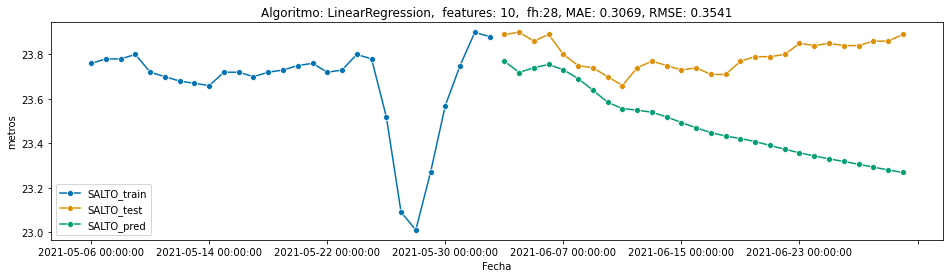

<Figure size 1152x288 with 0 Axes>

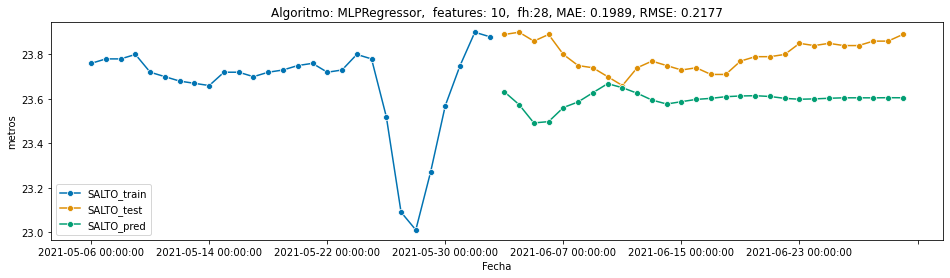

<Figure size 1152x288 with 0 Axes>

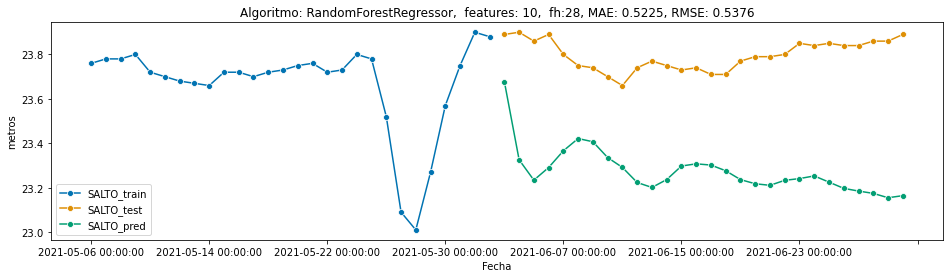

<Figure size 1152x288 with 0 Axes>

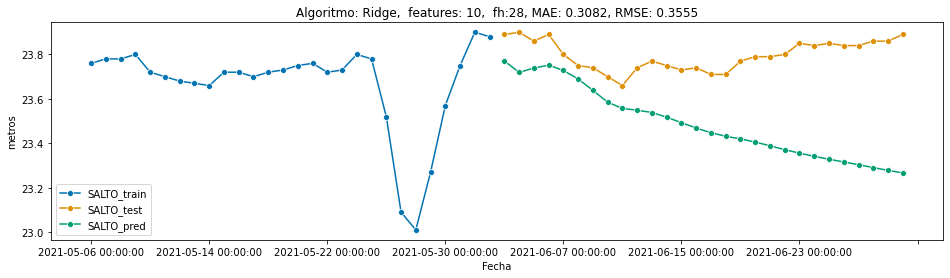

<Figure size 1152x288 with 0 Axes>

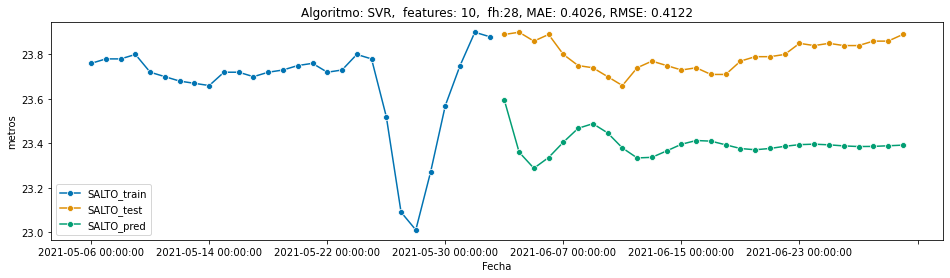

<Figure size 1152x288 with 0 Axes>

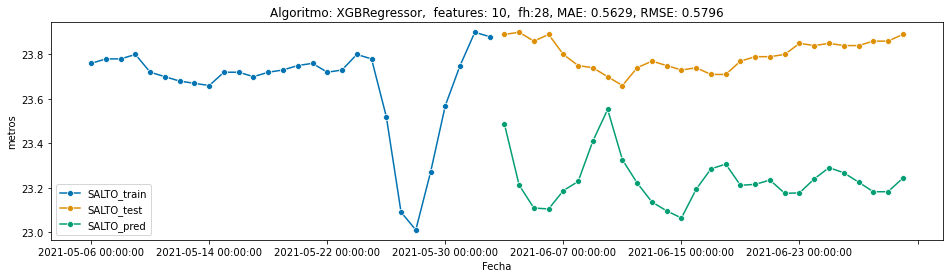

<Figure size 1152x288 with 0 Axes>

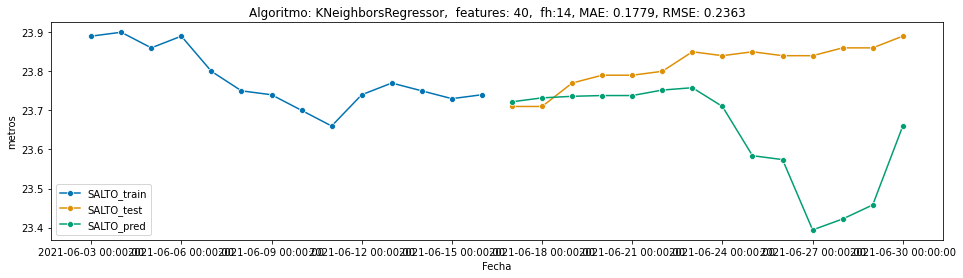

<Figure size 1152x288 with 0 Axes>

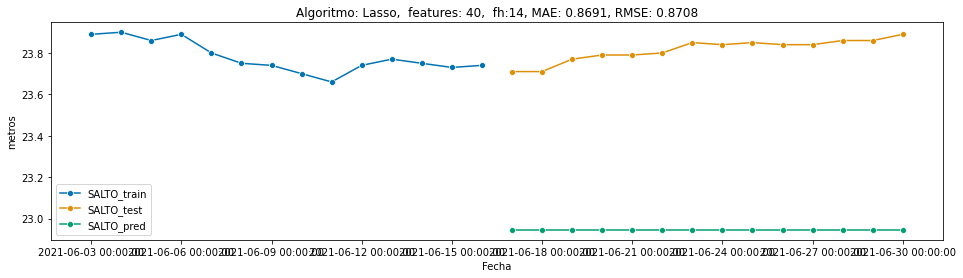

<Figure size 1152x288 with 0 Axes>

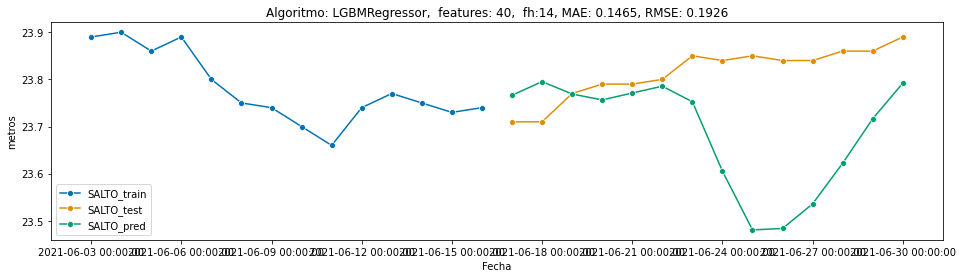

<Figure size 1152x288 with 0 Axes>

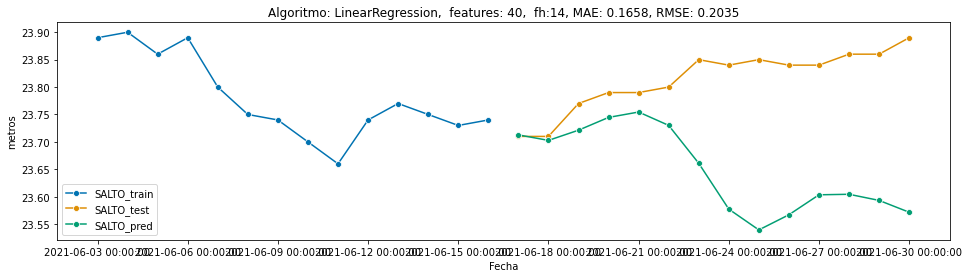

<Figure size 1152x288 with 0 Axes>

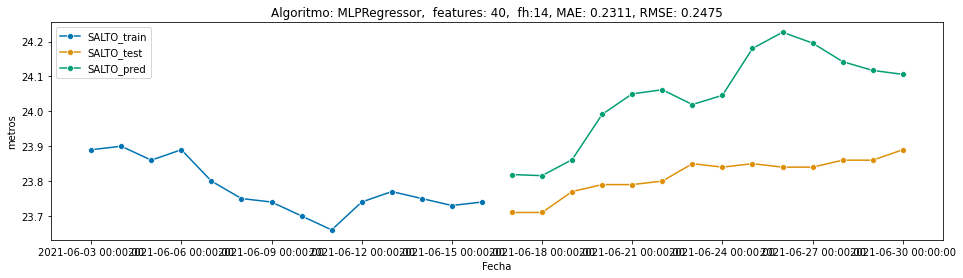

<Figure size 1152x288 with 0 Axes>

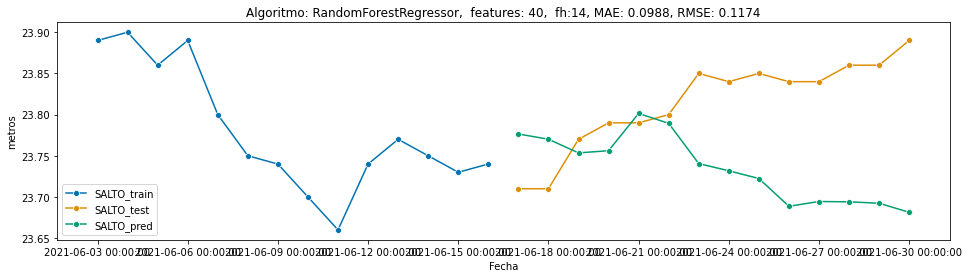

<Figure size 1152x288 with 0 Axes>

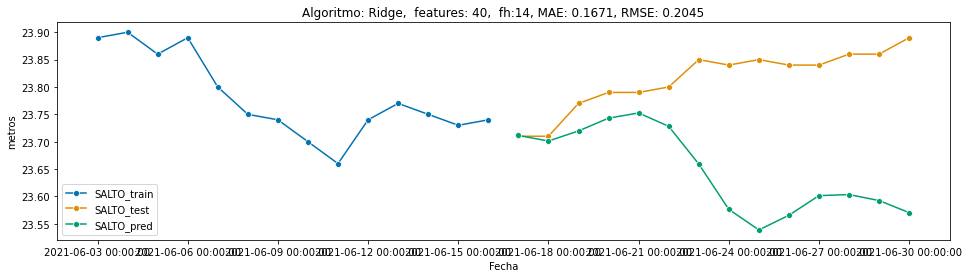

<Figure size 1152x288 with 0 Axes>

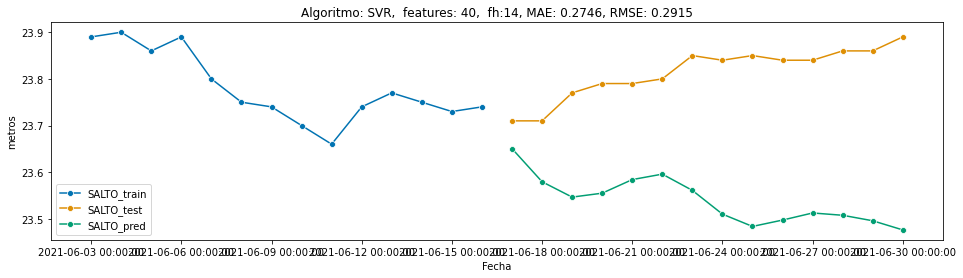

<Figure size 1152x288 with 0 Axes>

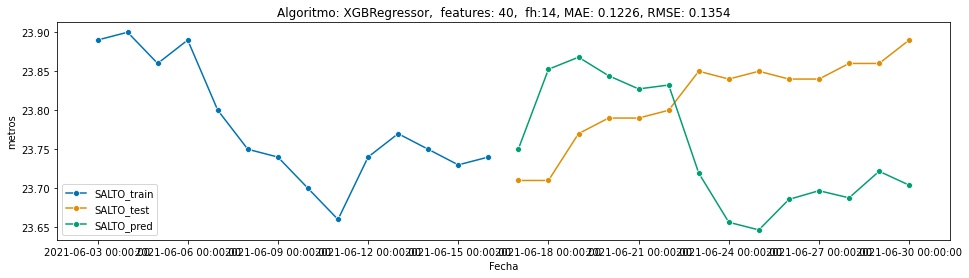

<Figure size 1152x288 with 0 Axes>

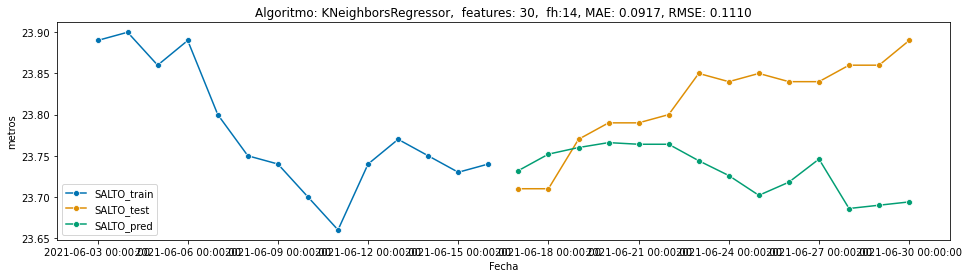

<Figure size 1152x288 with 0 Axes>

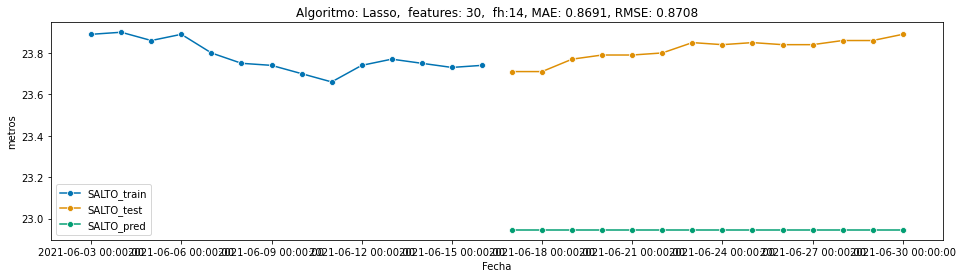

<Figure size 1152x288 with 0 Axes>

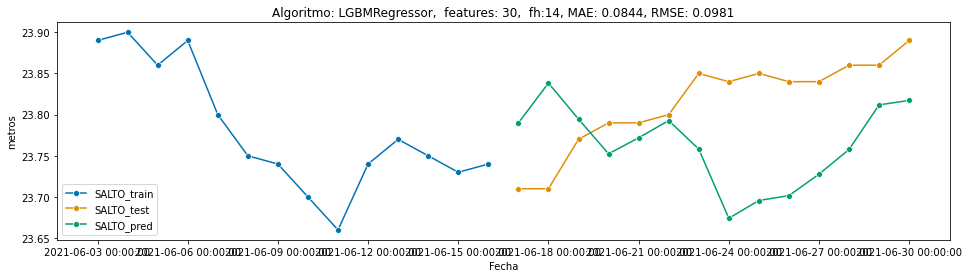

<Figure size 1152x288 with 0 Axes>

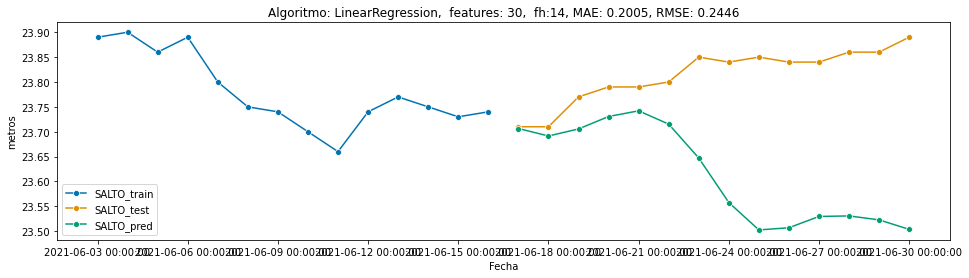

<Figure size 1152x288 with 0 Axes>

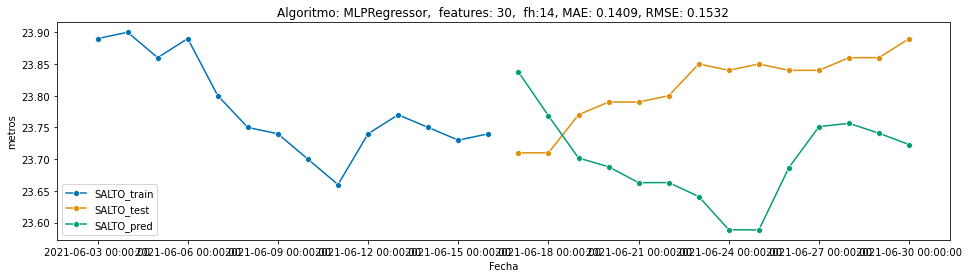

<Figure size 1152x288 with 0 Axes>

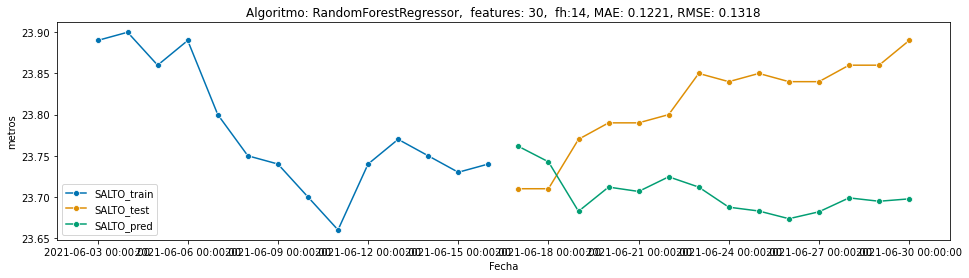

<Figure size 1152x288 with 0 Axes>

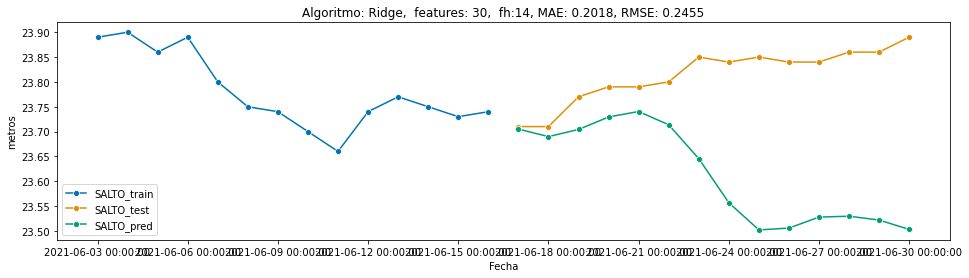

<Figure size 1152x288 with 0 Axes>

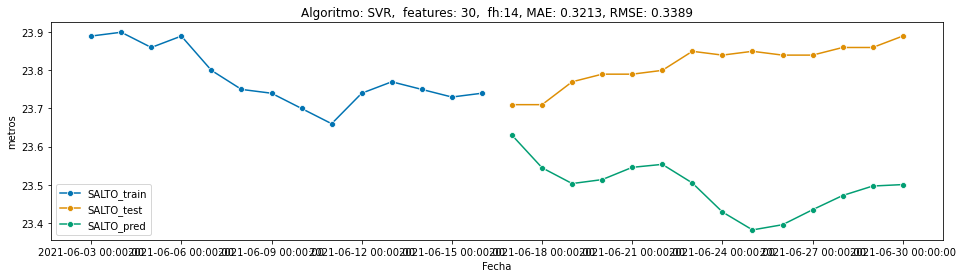

<Figure size 1152x288 with 0 Axes>

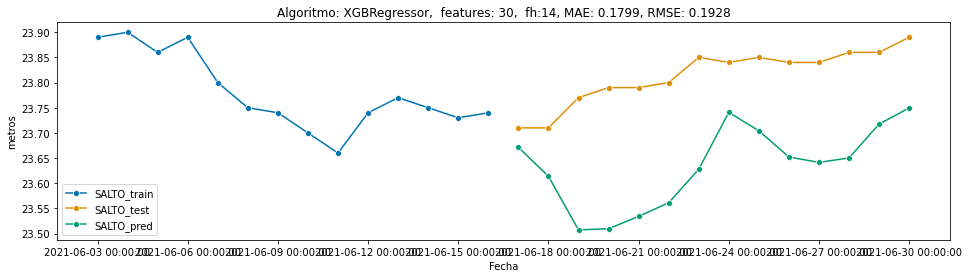

<Figure size 1152x288 with 0 Axes>

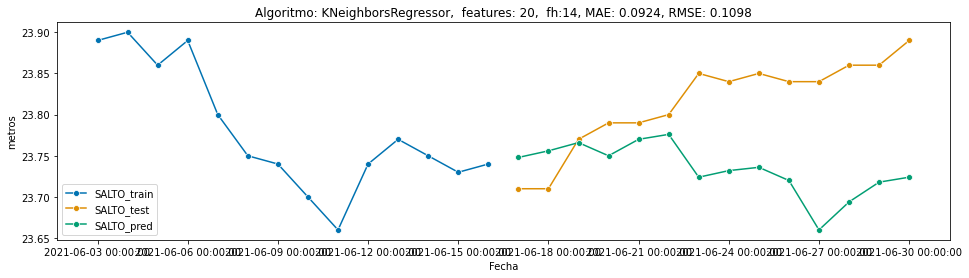

<Figure size 1152x288 with 0 Axes>

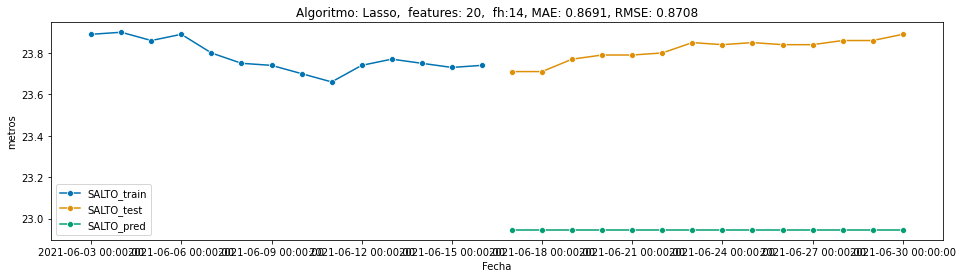

<Figure size 1152x288 with 0 Axes>

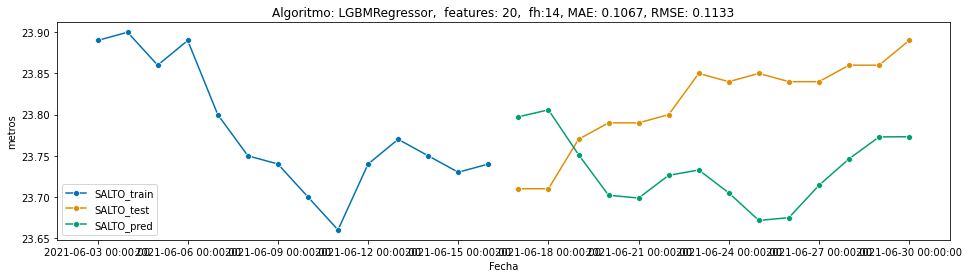

<Figure size 1152x288 with 0 Axes>

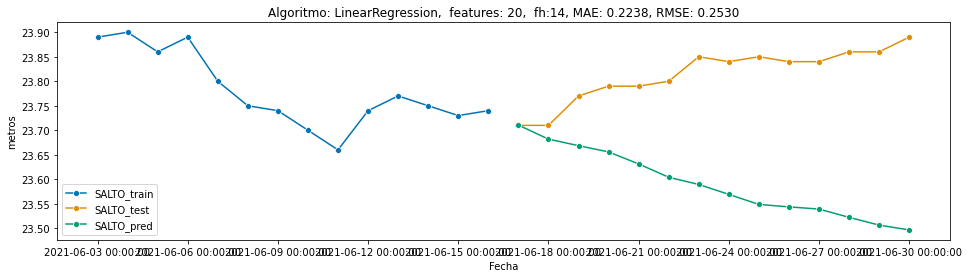

<Figure size 1152x288 with 0 Axes>

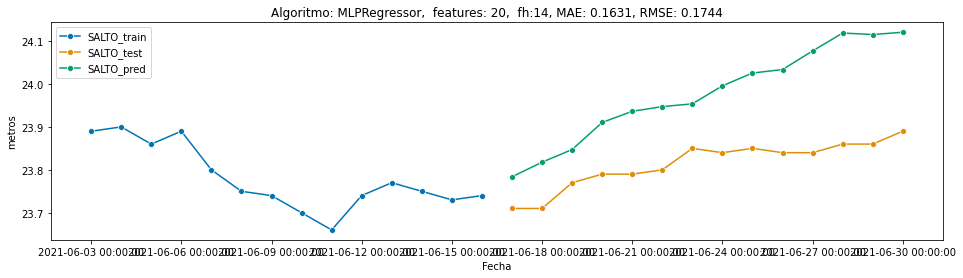

<Figure size 1152x288 with 0 Axes>

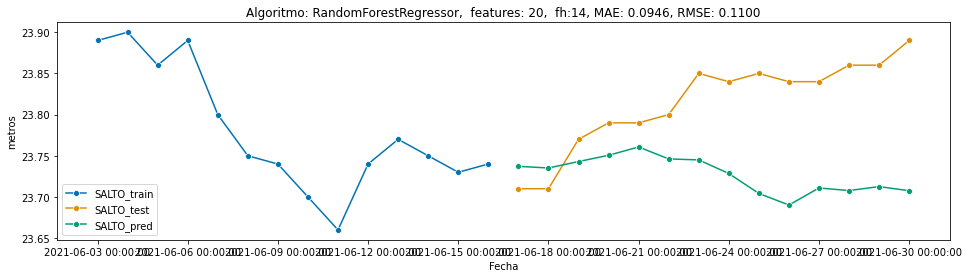

<Figure size 1152x288 with 0 Axes>

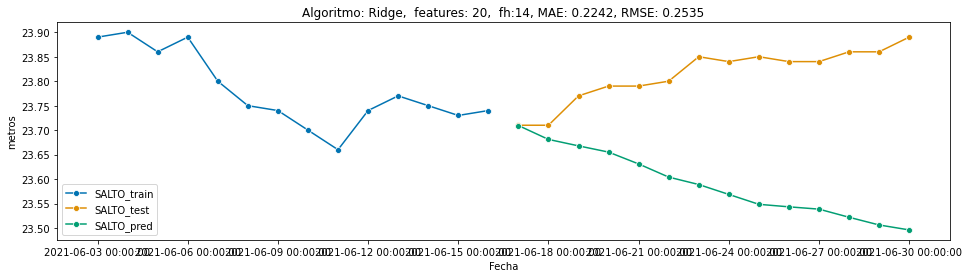

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



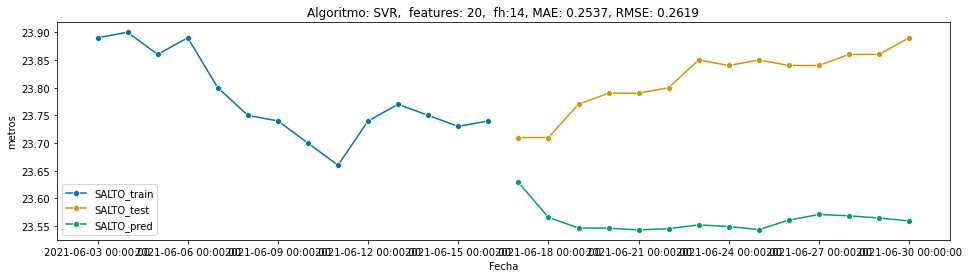

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



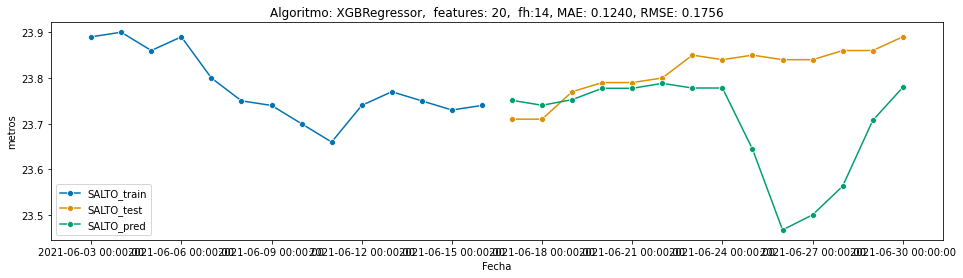

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



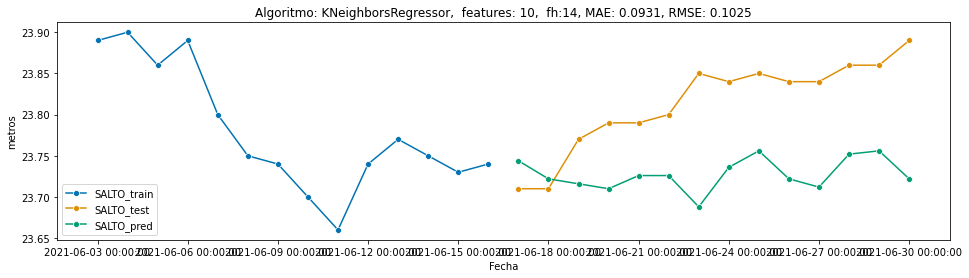

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



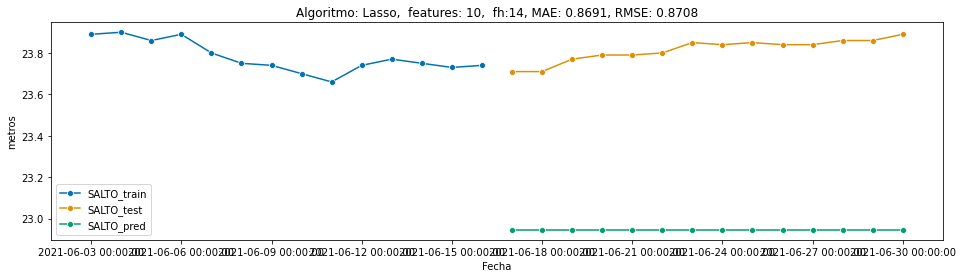

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



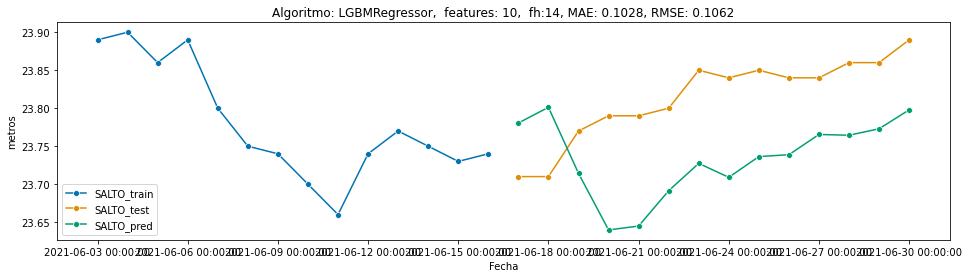

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



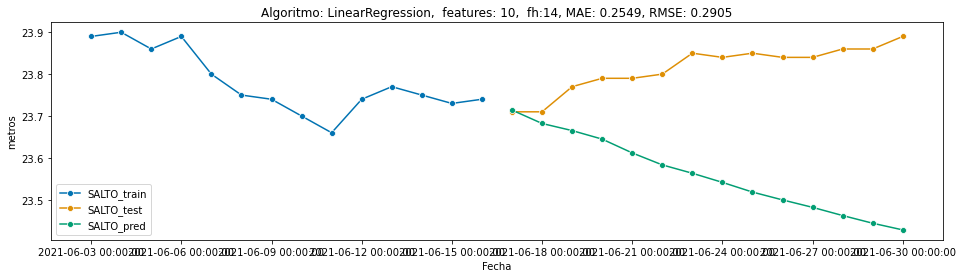

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



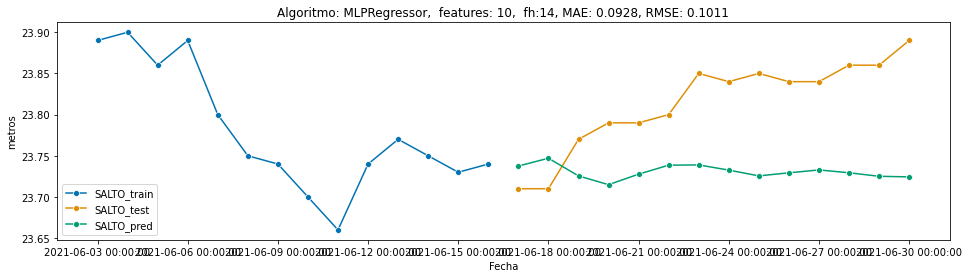

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



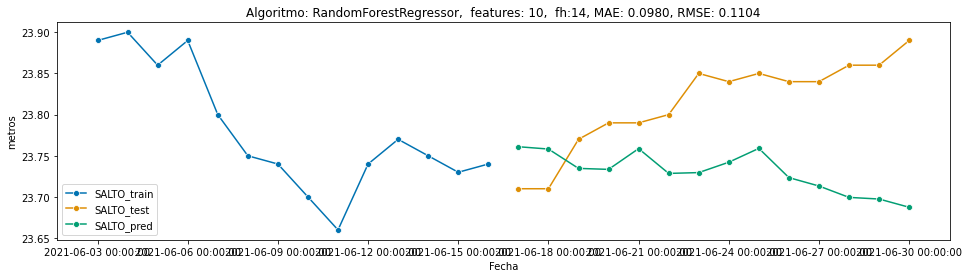

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



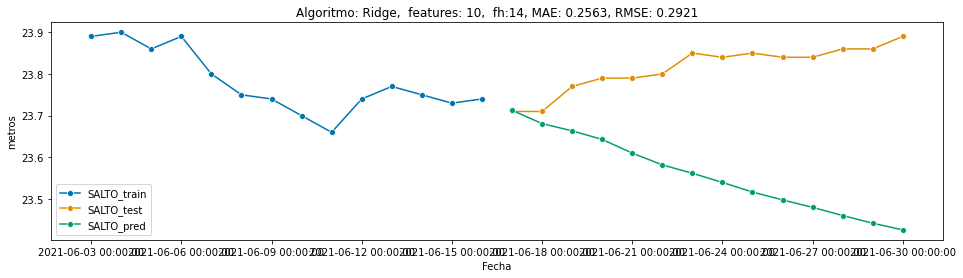

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



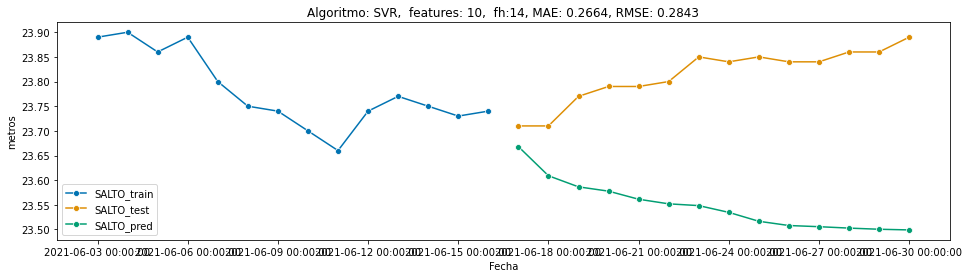

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



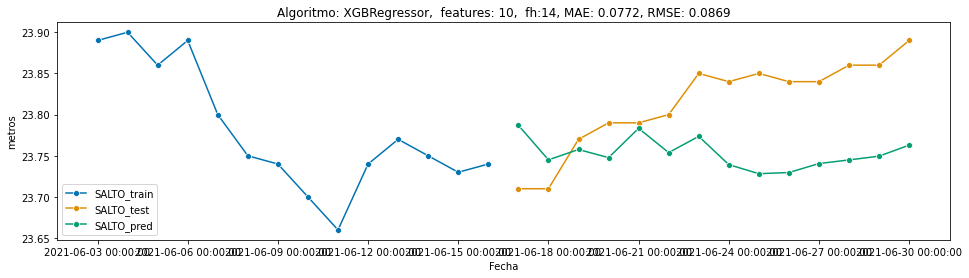

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:18: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



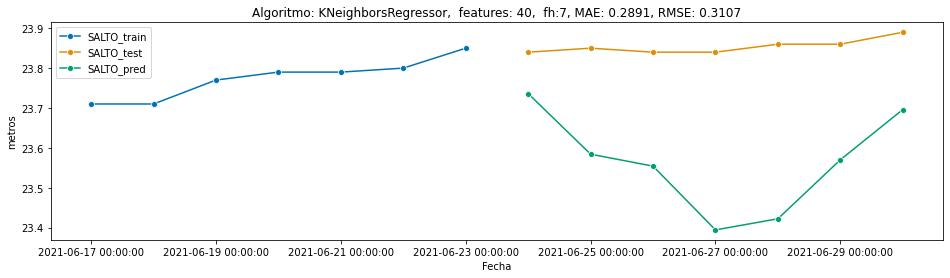

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



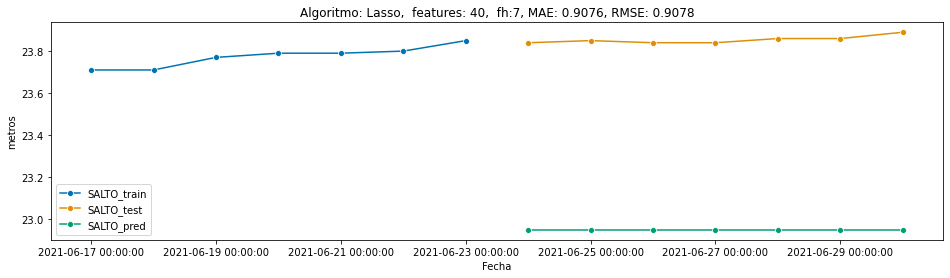

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



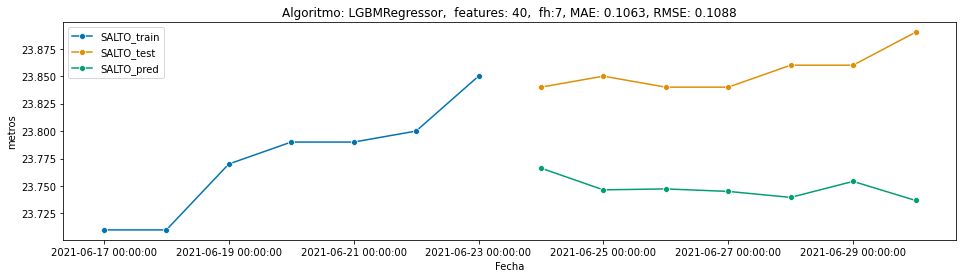

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



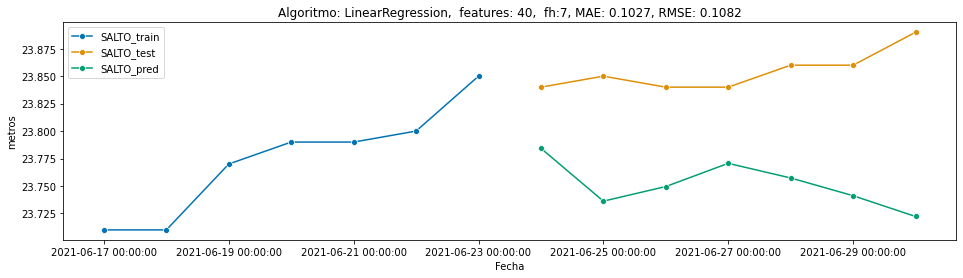

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



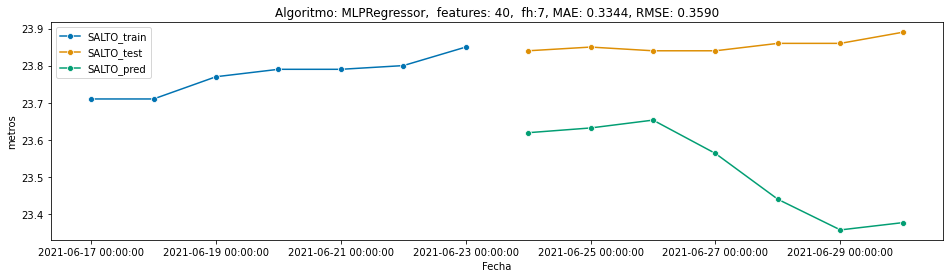

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



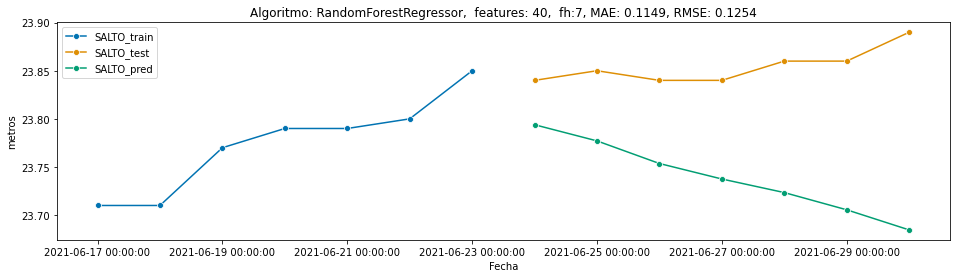

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



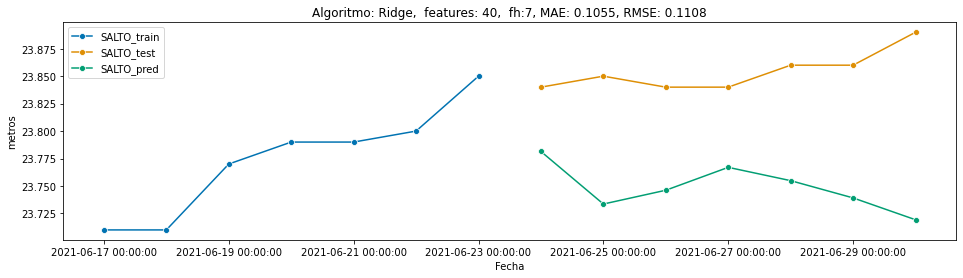

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



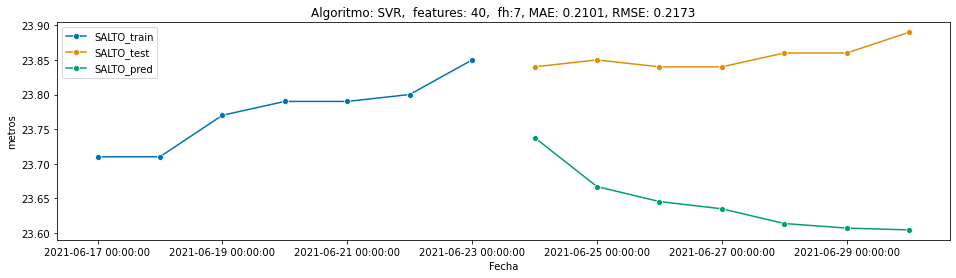

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



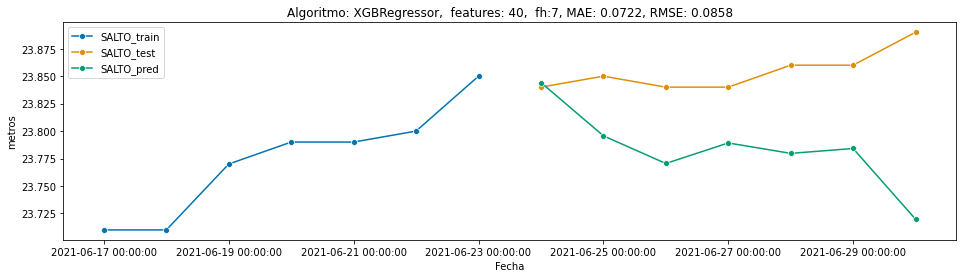

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



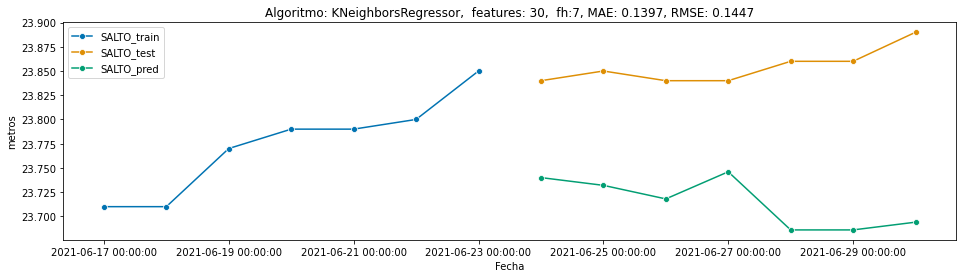

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



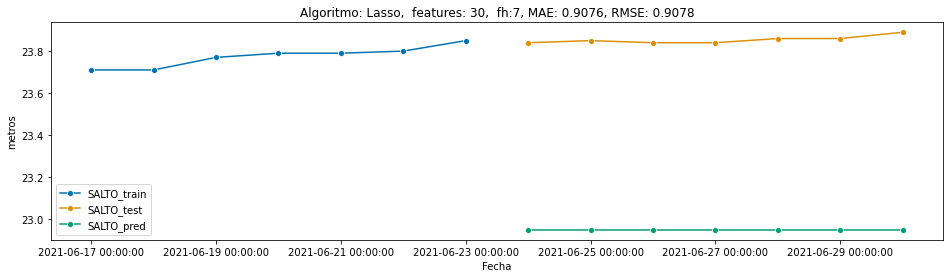

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



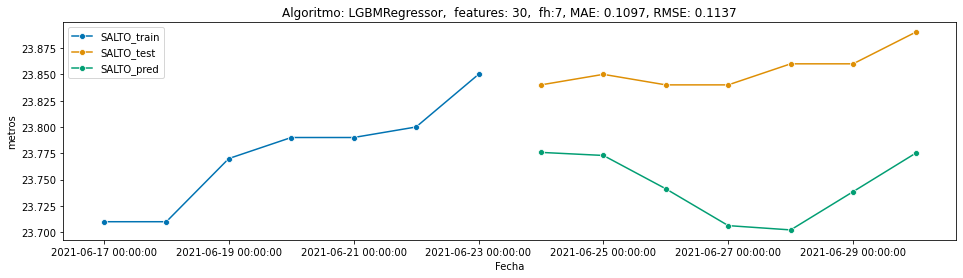

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



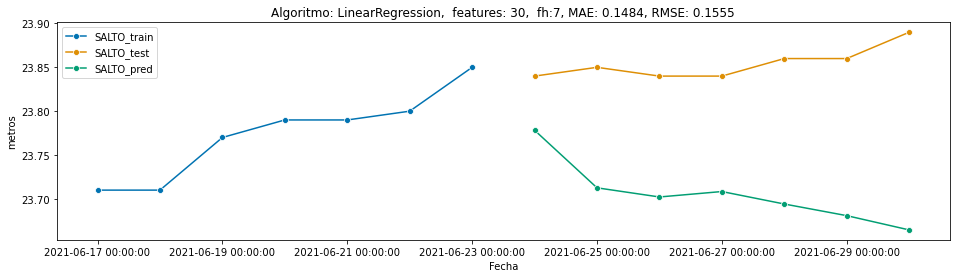

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



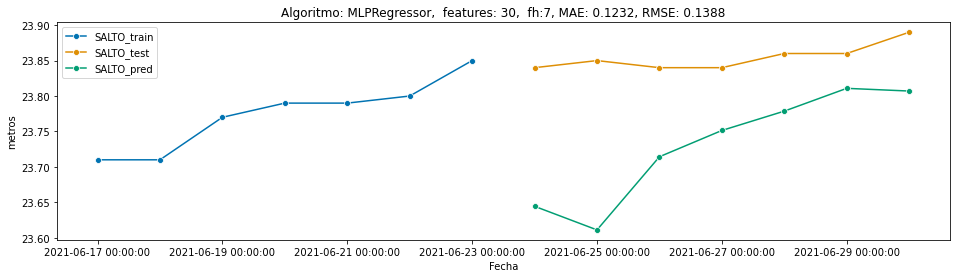

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



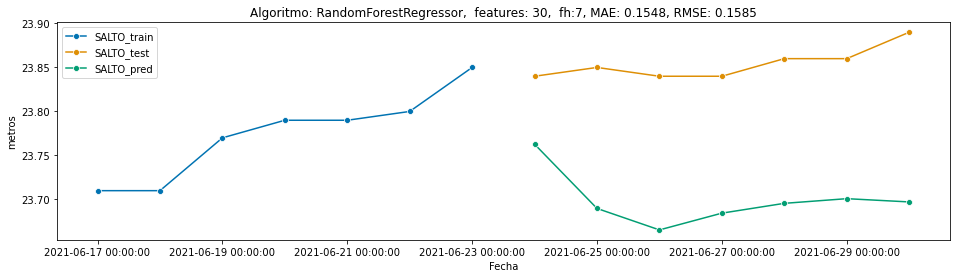

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



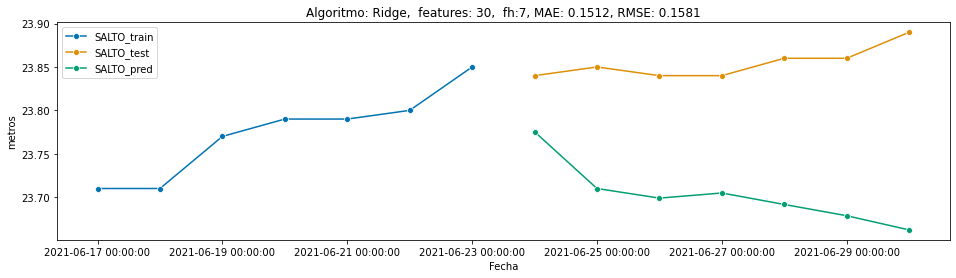

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



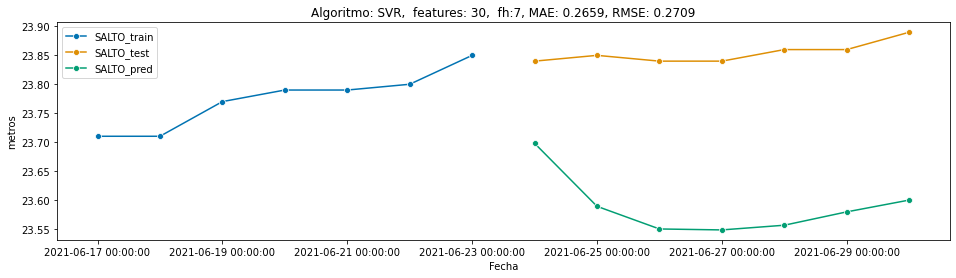

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



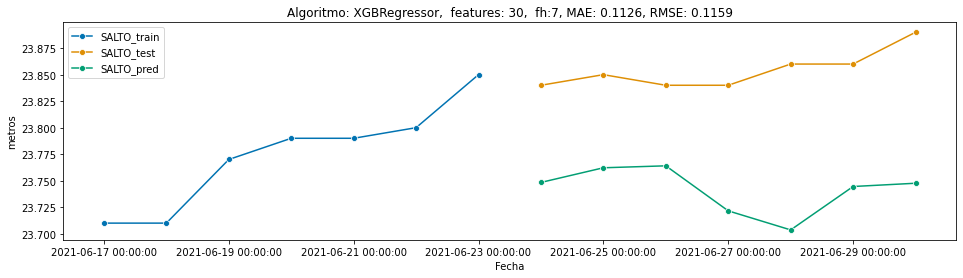

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



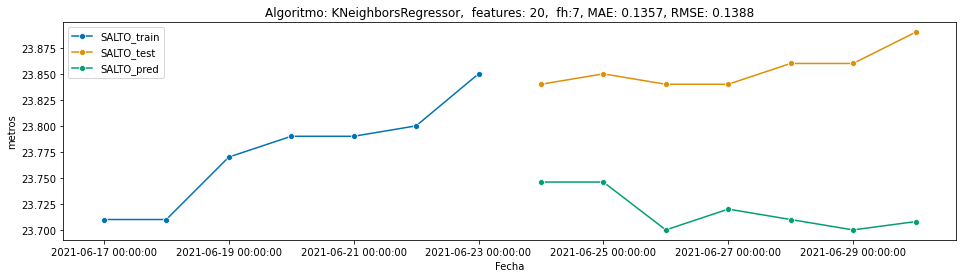

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



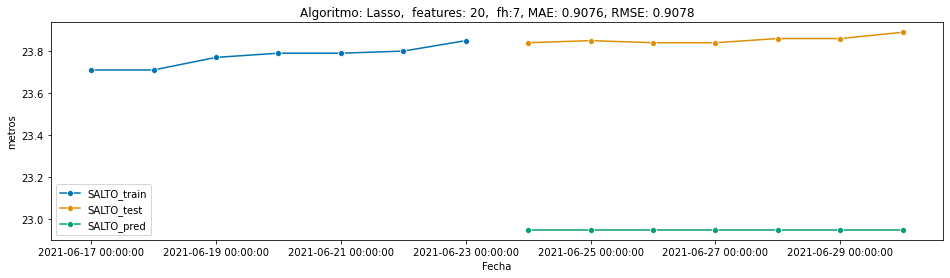

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



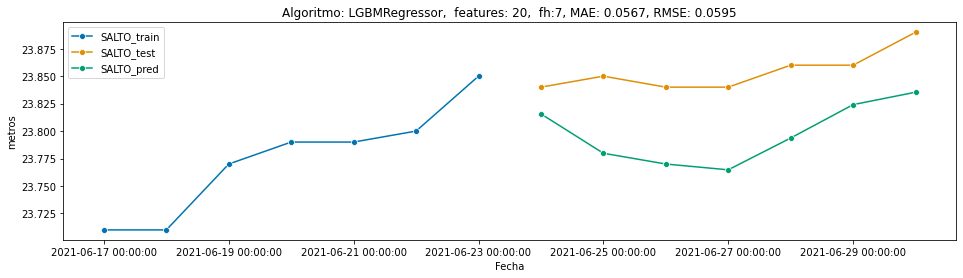

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



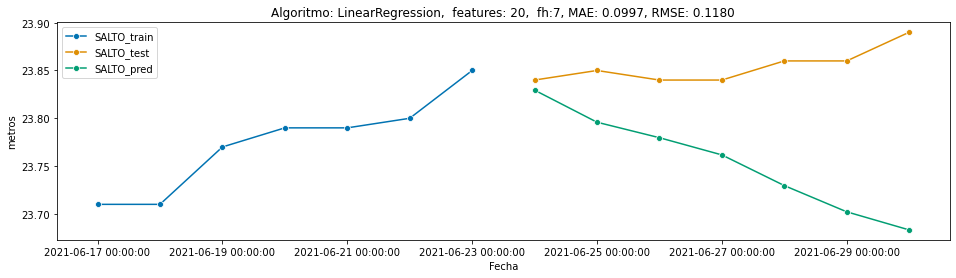

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



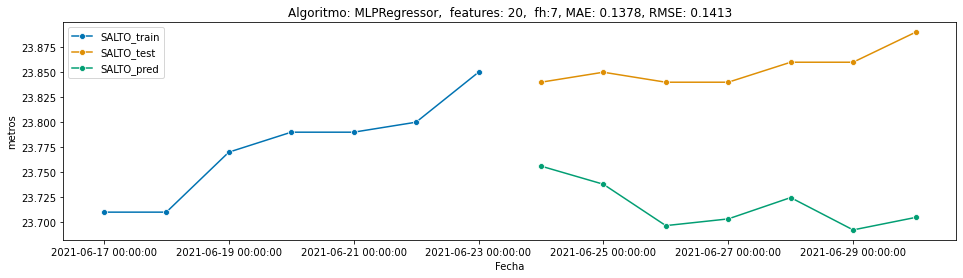

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



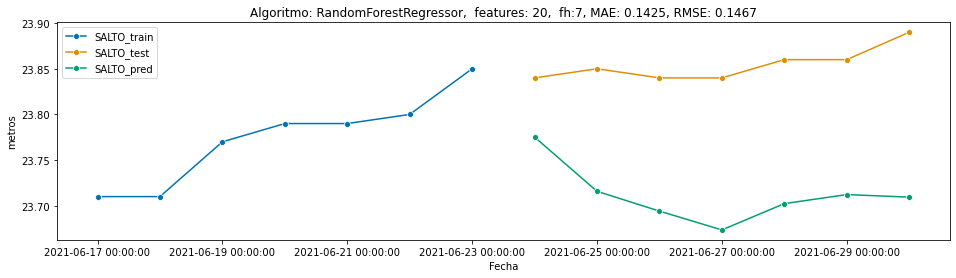

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



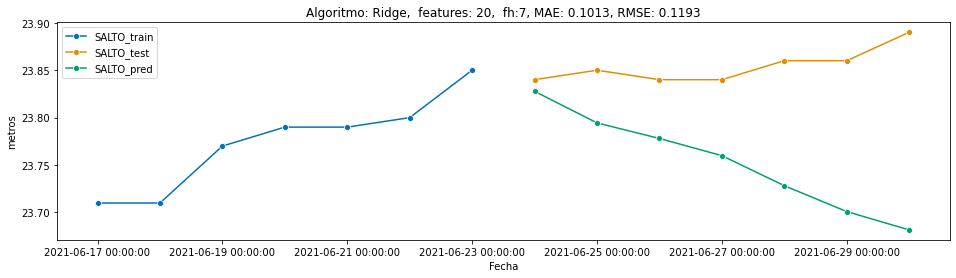

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



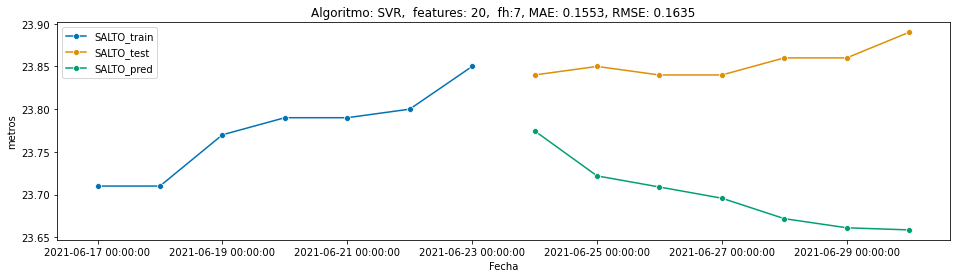

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



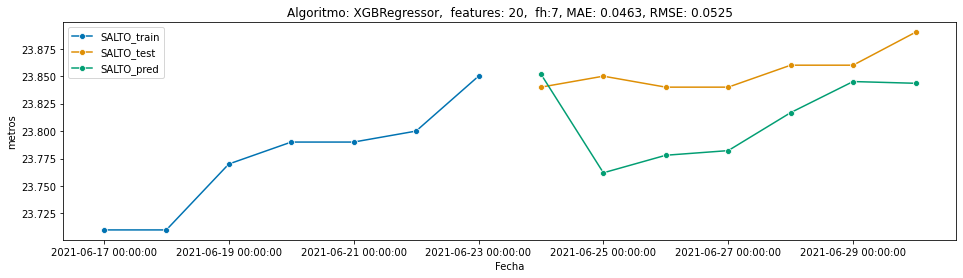

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



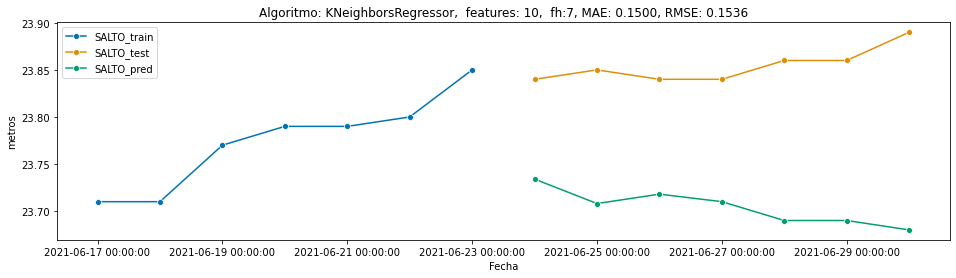

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



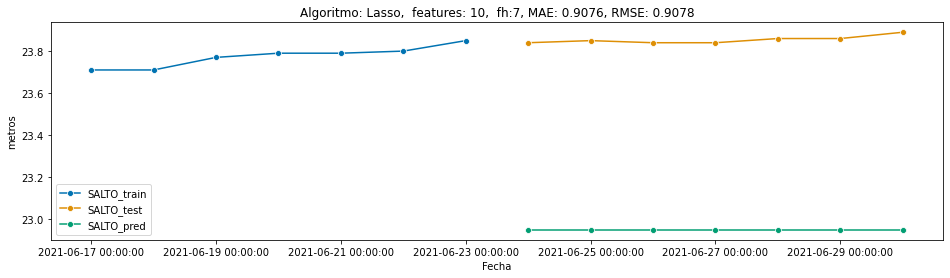

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



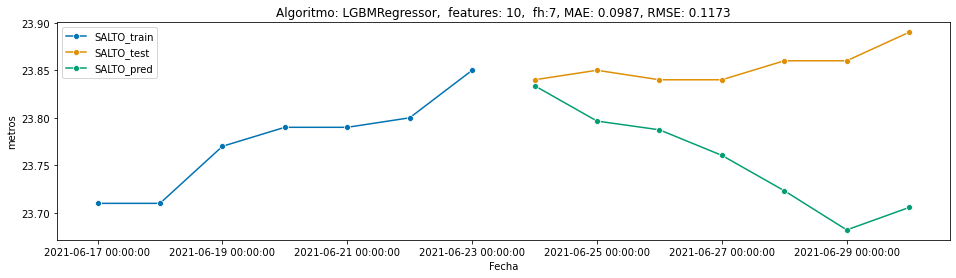

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



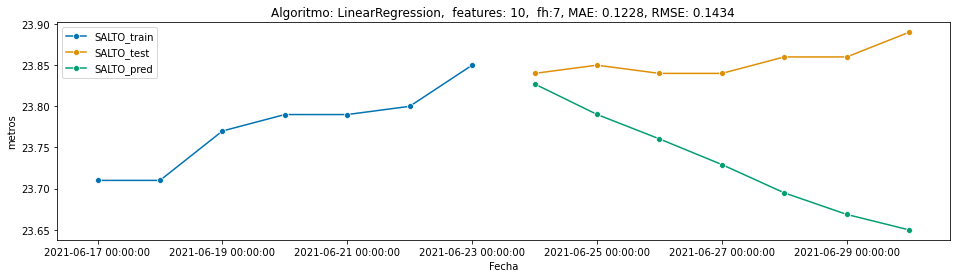

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



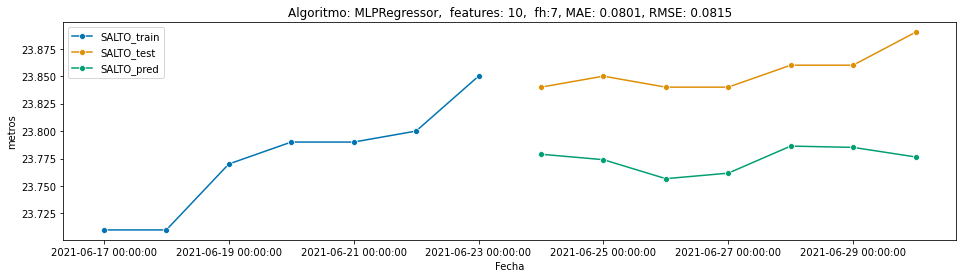

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



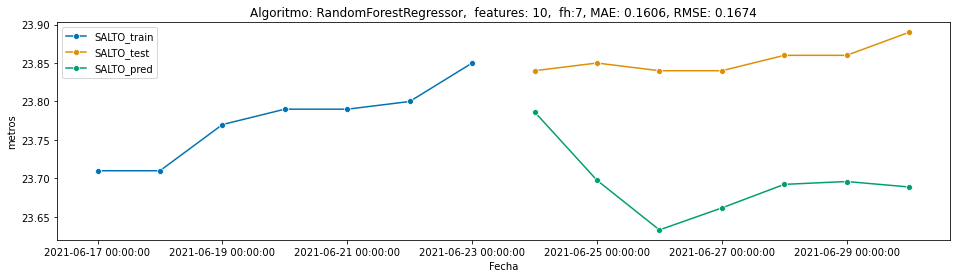

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



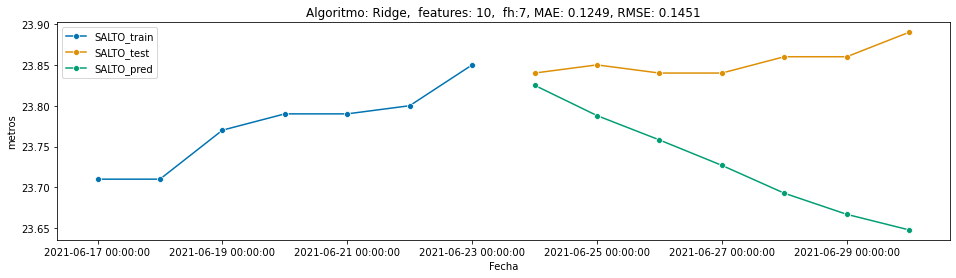

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



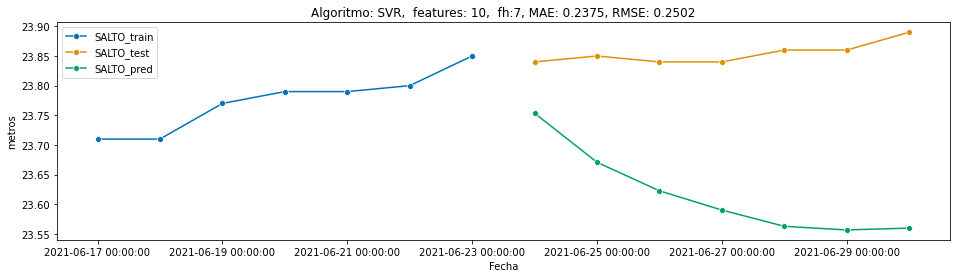

<Figure size 1152x288 with 0 Axes>

C:\Users\josel\AppData\Local\Temp/ipykernel_14960/691226421.py:56: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



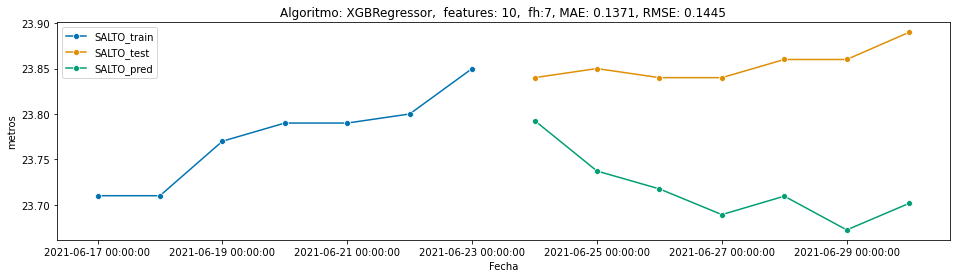

<Figure size 1152x288 with 0 Axes>

In [23]:
# Lista para las metricas
metricas = []

# Dataframe para los pronósticos
y_preds = pd.DataFrame()

# Lazo de cálculo

# Lazo de los horizontes de predicción
for fh in fh_s:
    
    # Extraigo las últimas fh filas del dataframe X
    y_train = y.iloc[:-fh]

    # Conjunto de target de testeo 
    y_test = y.iloc[-fh:]
    
    y_preds[str(fh) + '_' + 'y_test'] = y_test

    # Lazo de los conjuntos de lags
    for lags in lags_s:

        # Selecciono lag features para X_train
        X_train = X.iloc[:-fh, 0:lags]

        # Lazo de los regresores
        for regresor in regresores:

            # Ajusto el modelo
            regresor.fit(X_train, y_train)

            # Tomo la última fila
            X_pred = X_train.iloc[-1:,]

            # Creo el vector, tomando Copio el último valor de y_test
            y_pred = y_train.iloc[-1:]

            for i in range(0, fh):

                # Desplazo la serie X_pred hacia la derecha (SALTO-1 -> SALTO-2, SALTO-2 -> SALTO-3, etc.)
                X_pred = X_pred.shift(periods=1, axis=1)

                # Relleno el elemento de X_test que se hizo NaN por el desplazamiento
                X_pred['SALTO-01'] = y_pred.iloc[-1:]

                # Incremento el index de X_test
                X_pred.index = X_pred.index.shift(periods=1, freq='D')

                # Predigo con los valores de X_test, convirtiendo el array resultante a serie
                y_pred[X_pred.iloc[-1:,].index[0]] = regresor.predict(X_pred)[0]   

            # Quito el primer valor que introduje para la creación de y_pred (y_train.iloc[-1:])
            y_pred = y_pred.iloc[1:]

            # Agrego la predicción al df de predicciones
            y_preds[str(fh)+'_' + str(lags) + '_' + type(regresor).__name__] = y_pred

            # Calculo metricas
            MAE = mae(y_test, y_pred) 
            MSE = mse(y_test, y_pred)
            RMSE = rmse(y_true=y_test, y_pred=y_pred) 
            MASE = mase(y_true=y_test, y_pred=y_pred, y_train=y_train)

            metricas.append({'fh': fh
                             ,'lags':lags
                             ,'regresor': type(regresor).__name__
                             ,'MAE': MAE
                             ,'MSE': MSE
                             ,'RMSE': RMSE
                             ,'MASE': MASE
                            })

            # Ploteo los resultados del regresor/lags
            titulo = 'Algoritmo: ' + type(regresor).__name__  + ',  features: ' + str(lags) + ',  fh:'+ str(fh) + ', MAE: ' + f'{MAE:0.4f}' + ', RMSE: ' + f'{RMSE:0.4f}'
            fig, ax = plot_series(y_train[-fh:], y_test, y_pred, labels=["SALTO_train", "SALTO_test", "SALTO_pred"], 
                                  x_label='Fecha', y_label='metros')
            plt.figure(figsize=(16, 4))
            ax.set_title(titulo)
            ax.tick_params(axis='x', labelrotation = 0)
            plt.show()

#         # Ploteo las predicciones de todos los regresores
#         y_preds.iplot(kind='line'
#                   ,title='Pronósticos a '+ str(fh) + 'días y con ' + str(lags) + ' variables' 
#                   ,yTitle='metros'
#                   ,xTitle='Fecha'
#                   ,dimensions=(950, 700)
#                   ,theme='pearl'
#                   )


### Análisis de las métricas

In [24]:
# Creo un dataframe con la lista de métricas
metricas_df = pd.DataFrame(metricas)


In [25]:
# Guardo el dataframe de métricas
metricas_df.to_csv(path_grabacion + 'metricas_df.csv', index=False)

#### Mínimos MAE

In [26]:
# Listo las combinaciones regresor/lags para el horizonte de pronóstico de 7 días 
metricas_df.loc[metricas_df['fh']==7].sort_values(['MAE'])

fh  lags               regresor       MAE       MSE      RMSE       MASE
134   7    20           XGBRegressor  0.046314  0.002759  0.052527   0.609408
128   7    20          LGBMRegressor  0.056664  0.003536  0.059468   0.745598
116   7    40           XGBRegressor  0.072174  0.007365  0.085822   0.949676
139   7    10           MLPRegressor  0.080116  0.006644  0.081512   1.054184
137   7    10          LGBMRegressor  0.098684  0.013758  0.117295   1.298497
129   7    20       LinearRegression  0.099737  0.013921  0.117986   1.312351
132   7    20                  Ridge  0.101289  0.014222  0.119257   1.332777
111   7    40       LinearRegression  0.102670  0.011697  0.108151   1.350950
114   7    40                  Ridge  0.105520  0.012278  0.110807   1.388455
110   7    40          LGBMRegressor  0.106317  0.011843  0.108825   1.398941
119   7    30          LGBMRegressor  0.109688  0.012934  0.113728   1.443299
125   7    30           XGBRegressor  0.112589  0.013426  0.115869   1.481468
113   7    40  RandomForestRegressor  0.114914  0.015733  0.125431   1.512062
138   7    10       LinearRegression  0.122809  0.020560  0.143387   1.615936
121   7    30           MLPRegressor  0.123177  0.019272  0.138822   1.620790
141   7    10                  Ridge  0.124940  0.021068  0.145148   1.643978
126   7    20    KNeighborsRegressor  0.135714  0.019268  0.138809   1.785752
143   7    10           XGBRegressor  0.137128  0.020867  0.144456   1.804354
130   7    20           MLPRegressor  0.137819  0.019960  0.141279   1.813446
117   7    30    KNeighborsRegressor  0.139714  0.020945  0.144722   1.838384
131   7    20  RandomForestRegressor  0.142500  0.021507  0.146652   1.875039
120   7    30       LinearRegression  0.148406  0.024196  0.155550   1.952755
135   7    10    KNeighborsRegressor  0.150000  0.023583  0.153569   1.973725
123   7    30                  Ridge  0.151193  0.025007  0.158136   1.989418
122   7    30  RandomForestRegressor  0.154836  0.025117  0.158482   2.037355
133   7    20                    SVR  0.155277  0.026724  0.163474   2.043166
140   7    10  RandomForestRegressor  0.160557  0.028021  0.167395   2.112638
115   7    40                    SVR  0.210094  0.047214  0.217288   2.764452
142   7    10                    SVR  0.237530  0.062594  0.250188   3.125456
124   7    30                    SVR  0.265852  0.073376  0.270880   3.498130
108   7    40    KNeighborsRegressor  0.289143  0.096552  0.310728   3.804591
112   7    40           MLPRegressor  0.334437  0.128913  0.359045   4.400577
127   7    20                  Lasso  0.907603  0.824024  0.907758  11.942391
109   7    40                  Lasso  0.907603  0.824024  0.907758  11.942391
136   7    10                  Lasso  0.907603  0.824024  0.907758  11.942391
118   7    30                  Lasso  0.907603  0.824024  0.907758  11.942391

In [27]:
# Listo las combinaciones regresor/lags para el horizonte de pronóstico de 7 días 
metricas_df.loc[metricas_df['fh']==14].sort_values(['MAE'])

fh  lags               regresor       MAE       MSE      RMSE       MASE
107  14    10           XGBRegressor  0.077188  0.007551  0.086894   1.014369
83   14    30          LGBMRegressor  0.084404  0.009631  0.098135   1.109203
81   14    30    KNeighborsRegressor  0.091714  0.012310  0.110952   1.205273
90   14    20    KNeighborsRegressor  0.092429  0.012055  0.109793   1.214660
103  14    10           MLPRegressor  0.092832  0.010226  0.101123   1.219967
99   14    10    KNeighborsRegressor  0.093143  0.010507  0.102503   1.224047
95   14    20  RandomForestRegressor  0.094643  0.012097  0.109988   1.243759
104  14    10  RandomForestRegressor  0.097971  0.012184  0.110382   1.287502
77   14    40  RandomForestRegressor  0.098793  0.013776  0.117370   1.298297
101  14    10          LGBMRegressor  0.102797  0.011280  0.106209   1.350913
92   14    20          LGBMRegressor  0.106705  0.012838  0.113304   1.402270
86   14    30  RandomForestRegressor  0.122061  0.017367  0.131783   1.604074
80   14    40           XGBRegressor  0.122591  0.018336  0.135410   1.611046
98   14    20           XGBRegressor  0.124008  0.030822  0.175563   1.629660
85   14    30           MLPRegressor  0.140918  0.023483  0.153242   1.851888
74   14    40          LGBMRegressor  0.146477  0.037091  0.192591   1.924949
94   14    20           MLPRegressor  0.163130  0.030401  0.174359   2.143785
75   14    40       LinearRegression  0.165827  0.041422  0.203525   2.179227
78   14    40                  Ridge  0.167052  0.041838  0.204544   2.195325
72   14    40    KNeighborsRegressor  0.177857  0.055831  0.236286   2.337328
89   14    30           XGBRegressor  0.179936  0.037155  0.192755   2.364643
84   14    30       LinearRegression  0.200513  0.059824  0.244590   2.635064
87   14    30                  Ridge  0.201817  0.060295  0.245549   2.652197
93   14    20       LinearRegression  0.223769  0.064031  0.253043   2.940689
96   14    20                  Ridge  0.224237  0.064238  0.253451   2.946830
76   14    40           MLPRegressor  0.231056  0.061278  0.247545   3.036451
97   14    20                    SVR  0.253705  0.068573  0.261864   3.334096
102  14    10       LinearRegression  0.254871  0.084413  0.290540   3.349408
105  14    10                  Ridge  0.256331  0.085303  0.292067   3.368606
106  14    10                    SVR  0.266422  0.080830  0.284306   3.501210
79   14    40                    SVR  0.274647  0.084965  0.291488   3.609297
88   14    30                    SVR  0.321305  0.114855  0.338903   4.222459
82   14    30                  Lasso  0.869135  0.758221  0.870759  11.421834
100  14    10                  Lasso  0.869135  0.758221  0.870759  11.421834
73   14    40                  Lasso  0.869135  0.758221  0.870759  11.421834
91   14    20                  Lasso  0.869135  0.758221  0.870759  11.421834

In [28]:
# Listo las combinaciones regresor/lags para el horizonte de pronóstico de 7 días 
metricas_df.loc[metricas_df['fh']==28].sort_values(['MAE'])

fh  lags               regresor       MAE       MSE      RMSE       MASE
41  28    40  RandomForestRegressor  0.083811  0.009925  0.099624   1.099162
49  28    30           MLPRegressor  0.155411  0.036828  0.191907   2.038182
47  28    30          LGBMRegressor  0.184402  0.038728  0.196794   2.418396
39  28    40       LinearRegression  0.197648  0.055711  0.236032   2.592113
42  28    40                  Ridge  0.197985  0.055901  0.236435   2.596538
40  28    40           MLPRegressor  0.198553  0.052888  0.229974   2.603981
67  28    10           MLPRegressor  0.198946  0.047387  0.217685   2.609145
36  28    40    KNeighborsRegressor  0.227643  0.072136  0.268581   2.985493
48  28    30       LinearRegression  0.244963  0.084701  0.291034   3.212639
51  28    30                  Ridge  0.245141  0.084853  0.291296   3.214976
57  28    20       LinearRegression  0.249526  0.084747  0.291114   3.272485
60  28    20                  Ridge  0.249657  0.084864  0.291315   3.274209
38  28    40          LGBMRegressor  0.267931  0.097073  0.311566   3.513862
66  28    10       LinearRegression  0.306922  0.125414  0.354139   4.025218
69  28    10                  Ridge  0.308220  0.126373  0.355489   4.042248
43  28    40                    SVR  0.347701  0.127282  0.356766   4.560034
45  28    30    KNeighborsRegressor  0.350000  0.177838  0.421708   4.590184
44  28    40           XGBRegressor  0.365326  0.142876  0.377989   4.791175
56  28    20          LGBMRegressor  0.373294  0.151807  0.389625   4.895683
61  28    20                    SVR  0.400894  0.166739  0.408337   5.257656
70  28    10                    SVR  0.402628  0.169892  0.412180   5.280390
65  28    10          LGBMRegressor  0.441844  0.241759  0.491690   5.794697
52  28    30                    SVR  0.447839  0.214237  0.462857   5.873325
50  28    30  RandomForestRegressor  0.466454  0.230079  0.479666   6.117451
68  28    10  RandomForestRegressor  0.522539  0.289064  0.537647   6.853004
63  28    10    KNeighborsRegressor  0.540143  0.312395  0.558923   7.083872
59  28    20  RandomForestRegressor  0.544154  0.311035  0.557705   7.136471
71  28    10           XGBRegressor  0.562869  0.335920  0.579586   7.381921
62  28    20           XGBRegressor  0.622753  0.408036  0.638777   8.167284
54  28    20    KNeighborsRegressor  0.623286  0.407990  0.638741   8.174274
58  28    20           MLPRegressor  0.758051  0.683742  0.826887   9.941695
53  28    30           XGBRegressor  0.852561  0.946574  0.972920  11.181180
64  28    10                  Lasso  0.855096  0.735588  0.857664  11.214423
55  28    20                  Lasso  0.855096  0.735588  0.857664  11.214423
46  28    30                  Lasso  0.855096  0.735588  0.857664  11.214423
37  28    40                  Lasso  0.855096  0.735588  0.857664  11.214423

In [29]:
# Listo las combinaciones regresor/lags para el horizonte de pronóstico de 48 días 
metricas_df.loc[metricas_df['fh']==56].sort_values(['MAE'])

fh  lags               regresor       MAE       MSE      RMSE       MASE
18  56    20    KNeighborsRegressor  0.088393  0.024611  0.156881   1.159357
9   56    30    KNeighborsRegressor  0.091750  0.028889  0.169967   1.203390
27  56    10    KNeighborsRegressor  0.092250  0.026280  0.162111   1.209948
29  56    10          LGBMRegressor  0.092551  0.028078  0.167566   1.213899
35  56    10           XGBRegressor  0.096689  0.027520  0.165890   1.268171
13  56    30           MLPRegressor  0.097830  0.030812  0.175532   1.283132
26  56    20           XGBRegressor  0.100568  0.031849  0.178463   1.319047
31  56    10           MLPRegressor  0.103792  0.032801  0.181112   1.361336
22  56    20           MLPRegressor  0.135797  0.042092  0.205164   1.781104
23  56    20  RandomForestRegressor  0.140571  0.034670  0.186198   1.843730
20  56    20          LGBMRegressor  0.172527  0.044692  0.211405   2.262854
14  56    30  RandomForestRegressor  0.176184  0.054176  0.232758   2.310822
11  56    30          LGBMRegressor  0.185633  0.055422  0.235418   2.434752
32  56    10  RandomForestRegressor  0.222127  0.063986  0.252955   2.913407
0   56    40    KNeighborsRegressor  0.224893  0.061842  0.248680   2.949686
25  56    20                    SVR  0.265984  0.080364  0.283485   3.488641
2   56    40          LGBMRegressor  0.287220  0.105251  0.324424   3.767171
34  56    10                    SVR  0.299140  0.101365  0.318379   3.923510
8   56    40           XGBRegressor  0.314924  0.120153  0.346630   4.130534
3   56    40       LinearRegression  0.331065  0.138939  0.372745   4.342240
6   56    40                  Ridge  0.332234  0.139700  0.373765   4.357573
7   56    40                    SVR  0.345432  0.131446  0.362555   4.530677
21  56    20       LinearRegression  0.378120  0.186475  0.431827   4.959409
24  56    20                  Ridge  0.379126  0.187214  0.432683   4.972605
12  56    30       LinearRegression  0.383301  0.190631  0.436613   5.027365
15  56    30                  Ridge  0.384270  0.191387  0.437478   5.040069
5   56    40  RandomForestRegressor  0.414459  0.218105  0.467017   5.436028
4   56    40           MLPRegressor  0.442245  0.239938  0.489834   5.800470
16  56    30                    SVR  0.445023  0.220675  0.469761   5.836911
30  56    10       LinearRegression  0.460653  0.274392  0.523825   6.041901
33  56    10                  Ridge  0.462813  0.276595  0.525923   6.070235
17  56    30           XGBRegressor  0.567967  0.360696  0.600580   7.449433
28  56    10                  Lasso  0.795346  0.660131  0.812484  10.431731
10  56    30                  Lasso  0.795346  0.660131  0.812484  10.431731
1   56    40                  Lasso  0.795346  0.660131  0.812484  10.431731
19  56    20                  Lasso  0.795346  0.660131  0.812484  10.431731

#### Desempeño de los mejores modelos para cada fh

In [30]:
metricas_df.sort_values('MAE').groupby('fh').head(1).style.set_properties(**{'text-align': 'left'}).hide_index()

#### Desempeño de los 3 mejores modelos para cada fh

In [31]:
metricas_df.sort_values('MAE').groupby('fh').head(3).style.set_properties(**{'text-align': 'left'}).hide_index()

In [32]:
metricas_df.sort_values('MAE').groupby('fh').head(3) \
.pivot_table(index=['fh', 'lags'], columns='regresor', values='MAE') \
.iplot(kind='bar'
       ,sortbars=True
       ,xTitle='(Horizonte de pronóstico, nro. de lags)'
       ,yTitle='MAE (metros)'
       ,title='Desplazamiento diario - Desempeño de los tres mejores modelos'
       ,dimensions=(950, 350))


#### Desempeño de cada regresor

In [33]:
for lags in lags_s:
    metricas_df.loc[metricas_df['lags']==lags].sort_values(by=['fh', 'MAE']) \
    .iplot(kind='bar'
           ,x=['fh', 'regresor']
           ,y=['MAE', 'RMSE']
           ,title='Desplazamiento diario - Desempeño de cada modelo a '+ str(fh) + ' días y con ' + str(lags) + ' variables' 
           ,yTitle='metros'
           ,xTitle='Regresor'
           ,dimensions=(950, 500)
           ,theme='pearl'
           )

In [34]:
# Pivoteo el dataframe de métricas, para agrupar los MAE por nro. de lags
metricas_df.pivot_table(index=['fh', 'lags'], columns='regresor', values='MAE')

regresor  KNeighborsRegressor  LGBMRegressor     Lasso  LinearRegression  \
fh lags                                                                    
7  10                0.150000       0.098684  0.907603          0.122809   
   20                0.135714       0.056664  0.907603          0.099737   
   30                0.139714       0.109688  0.907603          0.148406   
   40                0.289143       0.106317  0.907603          0.102670   
14 10                0.093143       0.102797  0.869135          0.254871   
   20                0.092429       0.106705  0.869135          0.223769   
   30                0.091714       0.084404  0.869135          0.200513   
   40                0.177857       0.146477  0.869135          0.165827   
28 10                0.540143       0.441844  0.855096          0.306922   
   20                0.623286       0.373294  0.855096          0.249526   
   30                0.350000       0.184402  0.855096          0.244963   
   40                0.227643       0.267931  0.855096          0.197648   
56 10                0.092250       0.092551  0.795346          0.460653   
   20                0.088393       0.172527  0.795346          0.378120   
   30                0.091750       0.185633  0.795346          0.383301   
   40                0.224893       0.287220  0.795346          0.331065   

regresor  MLPRegressor  RandomForestRegressor     Ridge       SVR  \
fh lags                                                             
7  10         0.080116               0.160557  0.124940  0.237530   
   20         0.137819               0.142500  0.101289  0.155277   
   30         0.123177               0.154836  0.151193  0.265852   
   40         0.334437               0.114914  0.105520  0.210094   
14 10         0.092832               0.097971  0.256331  0.266422   
   20         0.163130               0.094643  0.224237  0.253705   
   30         0.140918               0.122061  0.201817  0.321305   
   40         0.231056               0.098793  0.167052  0.274647   
28 10         0.198946               0.522539  0.308220  0.402628   
   20         0.758051               0.544154  0.249657  0.400894   
   30         0.155411               0.466454  0.245141  0.447839   
   40         0.198553               0.083811  0.197985  0.347701   
56 10         0.103792               0.222127  0.462813  0.299140   
   20         0.135797               0.140571  0.379126  0.265984   
   30         0.097830               0.176184  0.384270  0.445023   
   40         0.442245               0.414459  0.332234  0.345432   

regresor  XGBRegressor  
fh lags                 
7  10         0.137128  
   20         0.046314  
   30         0.112589  
   40         0.072174  
14 10         0.077188  
   20         0.124008  
   30         0.179936  
   40         0.122591  
28 10         0.562869  
   20         0.622753  
   30         0.852561  
   40         0.365326  
56 10         0.096689  
   20         0.100568  
   30         0.567967  
   40         0.314924

#### Máximos, promedio y mínimos MAE por cada horizonte y número de lags

In [35]:
# Ploteo el mínimo MAE por cada nro. de lags
metricas_df.groupby(['fh', 'lags'])['MAE'].agg(['max', 'mean', 'min']).iplot(kind='bar'
                                                 ,title='MAE (máximo, promedio y mínimo), por horizonte de pronóstico y por número de features (lags)' 
                                                 ,yTitle='metros'
                                                 , xTitle='(horizonte de pronóstico, nro. de lags)'
                                                 ,dimensions=(950, 350)
                                                 ,theme='pearl'
                                                )

In [36]:
# Ploteo los MAE por nro de lags y por regresor
metricas_df.iplot(kind='bar'
                  ,x=['fh', 'lags', 'regresor']
                  ,y=['MAE']
                  ,title='MAE de cada regresor, por horizonte de pronóstico y por número de features (lags)' 
                  ,yTitle='metros'
                  ,xTitle='(horizonte de pronóstico, nro. de lags, regresor)'
                  ,dimensions=(950, 700)
                  ,theme='pearl'
                  ,barmode='group'
                  )

In [37]:
# Pivoteo el dataframe de métricas, para agrupar los MAE por nro. de lags
metricas_df.pivot_table(index=['fh', 'lags'], columns='regresor', values='MAE')

regresor  KNeighborsRegressor  LGBMRegressor     Lasso  LinearRegression  \
fh lags                                                                    
7  10                0.150000       0.098684  0.907603          0.122809   
   20                0.135714       0.056664  0.907603          0.099737   
   30                0.139714       0.109688  0.907603          0.148406   
   40                0.289143       0.106317  0.907603          0.102670   
14 10                0.093143       0.102797  0.869135          0.254871   
   20                0.092429       0.106705  0.869135          0.223769   
   30                0.091714       0.084404  0.869135          0.200513   
   40                0.177857       0.146477  0.869135          0.165827   
28 10                0.540143       0.441844  0.855096          0.306922   
   20                0.623286       0.373294  0.855096          0.249526   
   30                0.350000       0.184402  0.855096          0.244963   
   40                0.227643       0.267931  0.855096          0.197648   
56 10                0.092250       0.092551  0.795346          0.460653   
   20                0.088393       0.172527  0.795346          0.378120   
   30                0.091750       0.185633  0.795346          0.383301   
   40                0.224893       0.287220  0.795346          0.331065   

regresor  MLPRegressor  RandomForestRegressor     Ridge       SVR  \
fh lags                                                             
7  10         0.080116               0.160557  0.124940  0.237530   
   20         0.137819               0.142500  0.101289  0.155277   
   30         0.123177               0.154836  0.151193  0.265852   
   40         0.334437               0.114914  0.105520  0.210094   
14 10         0.092832               0.097971  0.256331  0.266422   
   20         0.163130               0.094643  0.224237  0.253705   
   30         0.140918               0.122061  0.201817  0.321305   
   40         0.231056               0.098793  0.167052  0.274647   
28 10         0.198946               0.522539  0.308220  0.402628   
   20         0.758051               0.544154  0.249657  0.400894   
   30         0.155411               0.466454  0.245141  0.447839   
   40         0.198553               0.083811  0.197985  0.347701   
56 10         0.103792               0.222127  0.462813  0.299140   
   20         0.135797               0.140571  0.379126  0.265984   
   30         0.097830               0.176184  0.384270  0.445023   
   40         0.442245               0.414459  0.332234  0.345432   

regresor  XGBRegressor  
fh lags                 
7  10         0.137128  
   20         0.046314  
   30         0.112589  
   40         0.072174  
14 10         0.077188  
   20         0.124008  
   30         0.179936  
   40         0.122591  
28 10         0.562869  
   20         0.622753  
   30         0.852561  
   40         0.365326  
56 10         0.096689  
   20         0.100568  
   30         0.567967  
   40         0.314924

#### MAE de cada regresor por horizonte y por conjunto de lags

In [38]:
# Ploteo los MAE para cada regresor, para cada nro. de lags
metricas_df.pivot_table(index=['fh', 'lags'], columns='regresor', values='MAE').iplot(kind='bar'
                                                                              ,title='MAE de cada regresor, por número de features (lags)'
                                                                              ,yTitle='metros'
                                                                              ,xTitle='(horizonde de pronóstico, nro. de lags)'
                                                                              ,dimensions=(950, 350)
                                                                              ,theme='pearl'
                                                                              )

In [39]:
# Busco el mínimo MAE
metricas_df[metricas_df['MAE']==metricas_df['MAE'].min()]

fh  lags      regresor       MAE       MSE      RMSE      MASE
134   7    20  XGBRegressor  0.046314  0.002759  0.052527  0.609408

In [40]:
# Busco el mínimo MAE
for fh in fh_s:
    metricas_df_fh = metricas_df[metricas_df['fh']==fh]
    print(metricas_df_fh[metricas_df_fh['MAE']==metricas_df_fh['MAE'].min()])

    fh  lags             regresor       MAE       MSE      RMSE      MASE
18  56    20  KNeighborsRegressor  0.088393  0.024611  0.156881  1.159357
    fh  lags               regresor       MAE       MSE      RMSE      MASE
41  28    40  RandomForestRegressor  0.083811  0.009925  0.099624  1.099162
     fh  lags      regresor       MAE       MSE      RMSE      MASE
107  14    10  XGBRegressor  0.077188  0.007551  0.086894  1.014369
     fh  lags      regresor       MAE       MSE      RMSE      MASE
134   7    20  XGBRegressor  0.046314  0.002759  0.052527  0.609408


#### Dataframe de pronósticos

In [41]:
#Imprimo el dataframe de pronósticos
y_preds

56_y_test  56_40_KNeighborsRegressor  56_40_Lasso  \
FECHA                                                           
2021-05-06      23.76                     23.618    22.936618   
2021-05-07      23.78                     23.562    22.936618   
2021-05-08      23.78                     23.486    22.936618   
2021-05-09      23.80                     23.486    22.936618   
2021-05-10      23.72                     23.466    22.936618   
2021-05-11      23.70                     23.472    22.936618   
2021-05-12      23.68                     23.478    22.936618   
2021-05-13      23.67                     23.478    22.936618   
2021-05-14      23.66                     23.514    22.936618   
2021-05-15      23.72                     23.514    22.936618   
2021-05-16      23.72                     23.514    22.936618   
2021-05-17      23.70                     23.546    22.936618   
2021-05-18      23.72                     23.586    22.936618   
2021-05-19      23.73                     23.586    22.936618   
2021-05-20      23.75                     23.616    22.936618   
2021-05-21      23.76                     23.648    22.936618   
2021-05-22      23.72                     23.646    22.936618   
2021-05-23      23.73                     23.642    22.936618   
2021-05-24      23.80                     23.646    22.936618   
2021-05-25      23.78                     23.654    22.936618   
2021-05-26      23.52                     23.654    22.936618   
2021-05-27      23.09                     23.620    22.936618   
2021-05-28      23.01                     23.476    22.936618   
2021-05-29      23.27                     23.476    22.936618   
2021-05-30      23.57                     23.476    22.936618   
2021-05-31      23.75                     23.476    22.936618   
2021-06-01      23.90                     23.420    22.936618   
2021-06-02      23.88                     23.438    22.936618   
2021-06-03      23.89                     23.546    22.936618   
2021-06-04      23.90                     23.586    22.936618   
2021-06-05      23.86                     23.616    22.936618   
2021-06-06      23.89                     23.648    22.936618   
2021-06-07      23.80                     23.646    22.936618   
2021-06-08      23.75                     23.642    22.936618   
2021-06-09      23.74                     23.646    22.936618   
2021-06-10      23.70                     23.646    22.936618   
2021-06-11      23.66                     23.654    22.936618   
2021-06-12      23.74                     23.620    22.936618   
2021-06-13      23.77                     23.476    22.936618   
2021-06-14      23.75                     23.476    22.936618   
2021-06-15      23.73                     23.476    22.936618   
2021-06-16      23.74                     23.406    22.936618   
2021-06-17      23.71                     23.350    22.936618   
2021-06-18      23.71                     23.472    22.936618   
2021-06-19      23.77                     23.478    22.936618   
2021-06-20      23.79                     23.478    22.936618   
2021-06-21      23.79                     23.514    22.936618   
2021-06-22      23.80                     23.514    22.936618   
2021-06-23      23.85                     23.546    22.936618   
2021-06-24      23.84                     23.586    22.936618   
2021-06-25      23.85                     23.616    22.936618   
2021-06-26      23.84                     23.648    22.936618   
2021-06-27      23.84                     23.646    22.936618   
2021-06-28      23.86                     23.642    22.936618   
2021-06-29      23.86                     23.646    22.936618   
2021-06-30      23.89                     23.654    22.936618   

            56_40_LGBMRegressor  56_40_LinearRegression  56_40_MLPRegressor  \
FECHA                                                                         
2021-05-06            23.731540               23.761190           23.676291   
2021

In [42]:
# Guardo el dataframe de las predicciones
y_preds.to_csv(path_grabacion + 'y_preds_df.csv')

In [43]:
y_preds[[col for col in y_preds.columns if col[0]=='7']].iplot()